Methods
- Method overview
    - GLM
    - Moving average
    - BMA clusters
- Data/case study
    - SWA Data
- Model formulation
- Model parametrisation
    - The GLM is parameterised by water, emission, and normalised by area with yield as the predicted variable.
    - Clusters is done along multiple axes
- Performance measures
- Sensitivity analysis 
    
Results
- Compare variables and their distributions
- Compare regions and their distributions
    - Look at the bias in data towards certain regions
    - And, look at the bias in recording of certain variables
- Look at the GLM
    - What regions stand out within the model and what does it explain
- Look at the clusters
     - Can this be explained by regional differences
- Sensitivity analysis

### We have to clean up the data a little bit for this analysis.

We are going to remove a swath of rows that do not include enough information. This means we will deal with a subset of the data that were willing to report enough variables for the analysis to make sense. The baseline variables are fuel, water, area and yield.

In [117]:
# We import some libraries and read in the data
from carbon_converter import *
from data import *
from graph import multihist

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rpy2
import rpy2.robjects as robjects
import rpy2.ipython.html

df = pd.read_feather('df.feather')
# TODO
# add nitrogen/fertiliser added together in data pipeline
df['nitrogen_applied'] = df['synthetic_nitrogen_applied']+df['organic_nitrogen_applied']
df['fertiliser_applied'] = df['synthetic_fertiliser_applied']+df['organic_fertiliser_applied']

# negative vineyard area harvested or likely typos
for id in df[df['area_harvested']<0.01].index:
    df = df.drop(index=id)
# remove radical outliers - caused mostly by incorrect units.
for id in df[df['water_used']>1000000].index:
    df = df.drop(index=id)

In [118]:
# There are some errors in spray data

df.loc[
    (df["insecticide_spraying_number_of_times_passes_per_year"]<1) & 
    (df["insecticide_spraying_number_of_times_passes_per_year"]!=0)
    , "insecticide_spraying_number_of_times_passes_per_year"] = 0


df.loc[
    (df["herbicide_spraying_number_of_times_passes_per_year"]<1) & 
    (df["herbicide_spraying_number_of_times_passes_per_year"]!=0)
    , "herbicide_spraying_number_of_times_passes_per_year"] = 0


In [119]:
# We convert the use of fuels into CO2E
# This includes both scope1 and scope 2 in the totals, as well as separate columns for comparison.
df["total_irrigation_electricity"] = df["total_irrigation_electricity"].apply(scope2)
df["irrigation_energy_diesel"] = df["irrigation_energy_diesel"].apply(diesel_irrigation)
df["irrigation_energy_electricity"] = df["irrigation_energy_electricity"].apply(scope2)
df["irrigation_energy_pressure"] = df["irrigation_energy_pressure"].apply(scope2)
df["diesel_vineyard"] = df["diesel_vineyard"].apply(diesel_vehicle)
df["electricity_vineyard"] = df["electricity_vineyard"].apply(scope2)
df["petrol_vineyard"] = df["petrol_vineyard"].apply(petrol_vehicle)
df["lpg_vineyard"] = df["lpg_vineyard"].apply(lpg_vehicle)
df["biodiesel_vineyard"] = df["biodiesel_vineyard"].apply(biodiesel_vehicle)

df["use_renewable"] = 0
df.loc[(df["irrigation_energy_solar"]>0) | (df["vineyard_wind"]>0) | (df["vineyard_solar"]),"use_renewable"] += 1

df["scope2"] = df["total_irrigation_electricity"]\
    + df["irrigation_energy_electricity"]\
    + df["irrigation_energy_pressure"]\
    + df["electricity_vineyard"]

df["scope1"] = df["irrigation_energy_diesel"]\
    + df["diesel_vineyard"]\
    + df["petrol_vineyard"]\
    + df["lpg_vineyard"]\
    + df["biodiesel_vineyard"]

df["total_emissions"] = df["scope1"] + df["scope2"]

In [120]:
# we limit it to recordings for the baseline variables.
df = df.replace({0: np.nan})
df = df[(df["area_harvested"].notnull()) & (df["tonnes_grapes_harvested"].notnull()) & (df["water_used"].notnull()) & (df["total_vineyard_fuel"].notnull())]

In [121]:
# We are going to transform the data so that it is distributed normally.
# This involves removing the top and bottom 1% as they contain several radicals
#
# These radicals may be mis recordings or freak events in the data. They are 
# disparate enough to remove.

log_df = df.copy()
log_df["area_harvested"] += 1

ids = []
for col in [
    "water_used"
    , "tonnes_grapes_harvested"
    , "total_vineyard_fuel"
    , "total_vineyard_electricity"
]:
    log_df[col] = log_df[col].apply(np.log).div(log_df["area_harvested"].apply(np.log))

    log_df = log_df.loc[
        log_df[col].sort_values().iloc[round(len(log_df)*.005):round(len(log_df)-len(df)*.005)].index
    ]

for col in [
    "total_emissions"
    , "scope1"
    , "scope2"
]:
    log_df[col] += 1
    log_df[col] = log_df[col].apply(np.log).div(log_df["area_harvested"].apply(np.log))

### We have a look at the sparsity of particular variables

In [122]:
feature_list = [
    "area_harvested"
    , "tonnes_grapes_harvested"
    , "water_used"
    , "total_tractor_passes"
    , "synthetic_nitrogen_applied"
    , "organic_nitrogen_applied"
    , "synthetic_fertiliser_applied"
    , "organic_fertiliser_applied"
    , "slashing_number_of_times_passes_per_year"
    , "fungicide_spraying_number_of_times_passes_per_year"
    , "herbicide_spraying_number_of_times_passes_per_year"
    , "insecticide_spraying_number_of_times_passes_per_year"
    , "nitrogen_applied"
    , "fertiliser_applied"
    , "total_emissions"
]

total = len(log_df)
print("n = {}".format(total))
print("Proportion of entries in each column:\n")
for feature in feature_list:
    entries = len(log_df[log_df[feature].notnull()][feature])
    print("{}: {} | {}%".format(feature, entries, round((entries/total)*100, 2)))

n = 5189
Proportion of entries in each column:

area_harvested: 5189 | 100.0%
tonnes_grapes_harvested: 5189 | 100.0%
water_used: 5189 | 100.0%
total_tractor_passes: 1873 | 36.1%
synthetic_nitrogen_applied: 133 | 2.56%
organic_nitrogen_applied: 131 | 2.52%
synthetic_fertiliser_applied: 409 | 7.88%
organic_fertiliser_applied: 292 | 5.63%
slashing_number_of_times_passes_per_year: 1837 | 35.4%
fungicide_spraying_number_of_times_passes_per_year: 1826 | 35.19%
herbicide_spraying_number_of_times_passes_per_year: 1650 | 31.8%
insecticide_spraying_number_of_times_passes_per_year: 889 | 17.13%
nitrogen_applied: 242 | 4.66%
fertiliser_applied: 591 | 11.39%
total_emissions: 5189 | 100.0%


### We look at the proportion of entries for each region:

In [123]:
total = len(log_df)
print("n = {}".format(total))
print("number of regions is {}".format(len(log_df["giregion"].unique())))
print("Proportion of entries in each column:\n")
for region in log_df["giregion"].unique():
    entries = len(log_df[log_df["giregion"]==region]["giregion"])
    print("{}: {} | {}%".format(region, entries, round((entries/total)*100, 2)))

n = 5189
number of regions is 56
Proportion of entries in each column:

McLaren Vale: 977 | 18.83%
Margaret River: 291 | 5.61%
Grampians: 68 | 1.31%
Barossa Valley: 493 | 9.5%
Adelaide Hills: 387 | 7.46%
Riverland: 427 | 8.23%
Murray Darling: 474 | 9.13%
Orange: 46 | 0.89%
Other: 18 | 0.35%
Eden Valley: 83 | 1.6%
Adelaide Plains: 23 | 0.44%
Coonawarra: 259 | 4.99%
Riverina: 16 | 0.31%
Hunter Valley: 50 | 0.96%
Padthaway: 178 | 3.43%
Langhorne Creek: 317 | 6.11%
Strathbogie Ranges: 4 | 0.08%
Clare Valley: 120 | 2.31%
Tumbarumba: 28 | 0.54%
Tasmania: 81 | 1.56%
Robe: 35 | 0.67%
Yarra Valley: 102 | 1.97%
Wrattonbully: 158 | 3.04%
Southern Fleurieu: 28 | 0.54%
Bendigo: 47 | 0.91%
Upper Goulburn: 20 | 0.39%
King Valley: 26 | 0.5%
Swan Hill: 82 | 1.58%
Blackwood Valley: 8 | 0.15%
Heathcote: 28 | 0.54%
Great Southern: 49 | 0.94%
Gundagai: 5 | 0.1%
Rutherglen: 27 | 0.52%
Currency Creek: 20 | 0.39%
Henty: 20 | 0.39%
Canberra District: 10 | 0.19%
Big Rivers Zone Other: 9 | 0.17%
Glenrowan: 4 | 0

In [124]:
log_df.groupby("giregion")["member_id"].count().describe()

count     56.000000
mean      92.660714
std      173.286235
min        1.000000
25%        9.750000
50%       22.500000
75%       81.250000
max      977.000000
Name: member_id, dtype: float64

In [125]:
region_selection = df.groupby("giregion").count()[(df.groupby("giregion").count()>50)["member_id"]].index.values
region_selection = list(region_selection).append("other")

### How do the variables correlate to each other

In [126]:
log_df[feature_list].corr().style.background_gradient(cmap='coolwarm')

### How are the varaible distributed

In [127]:
df = df.loc[log_df.index]
log_df = None

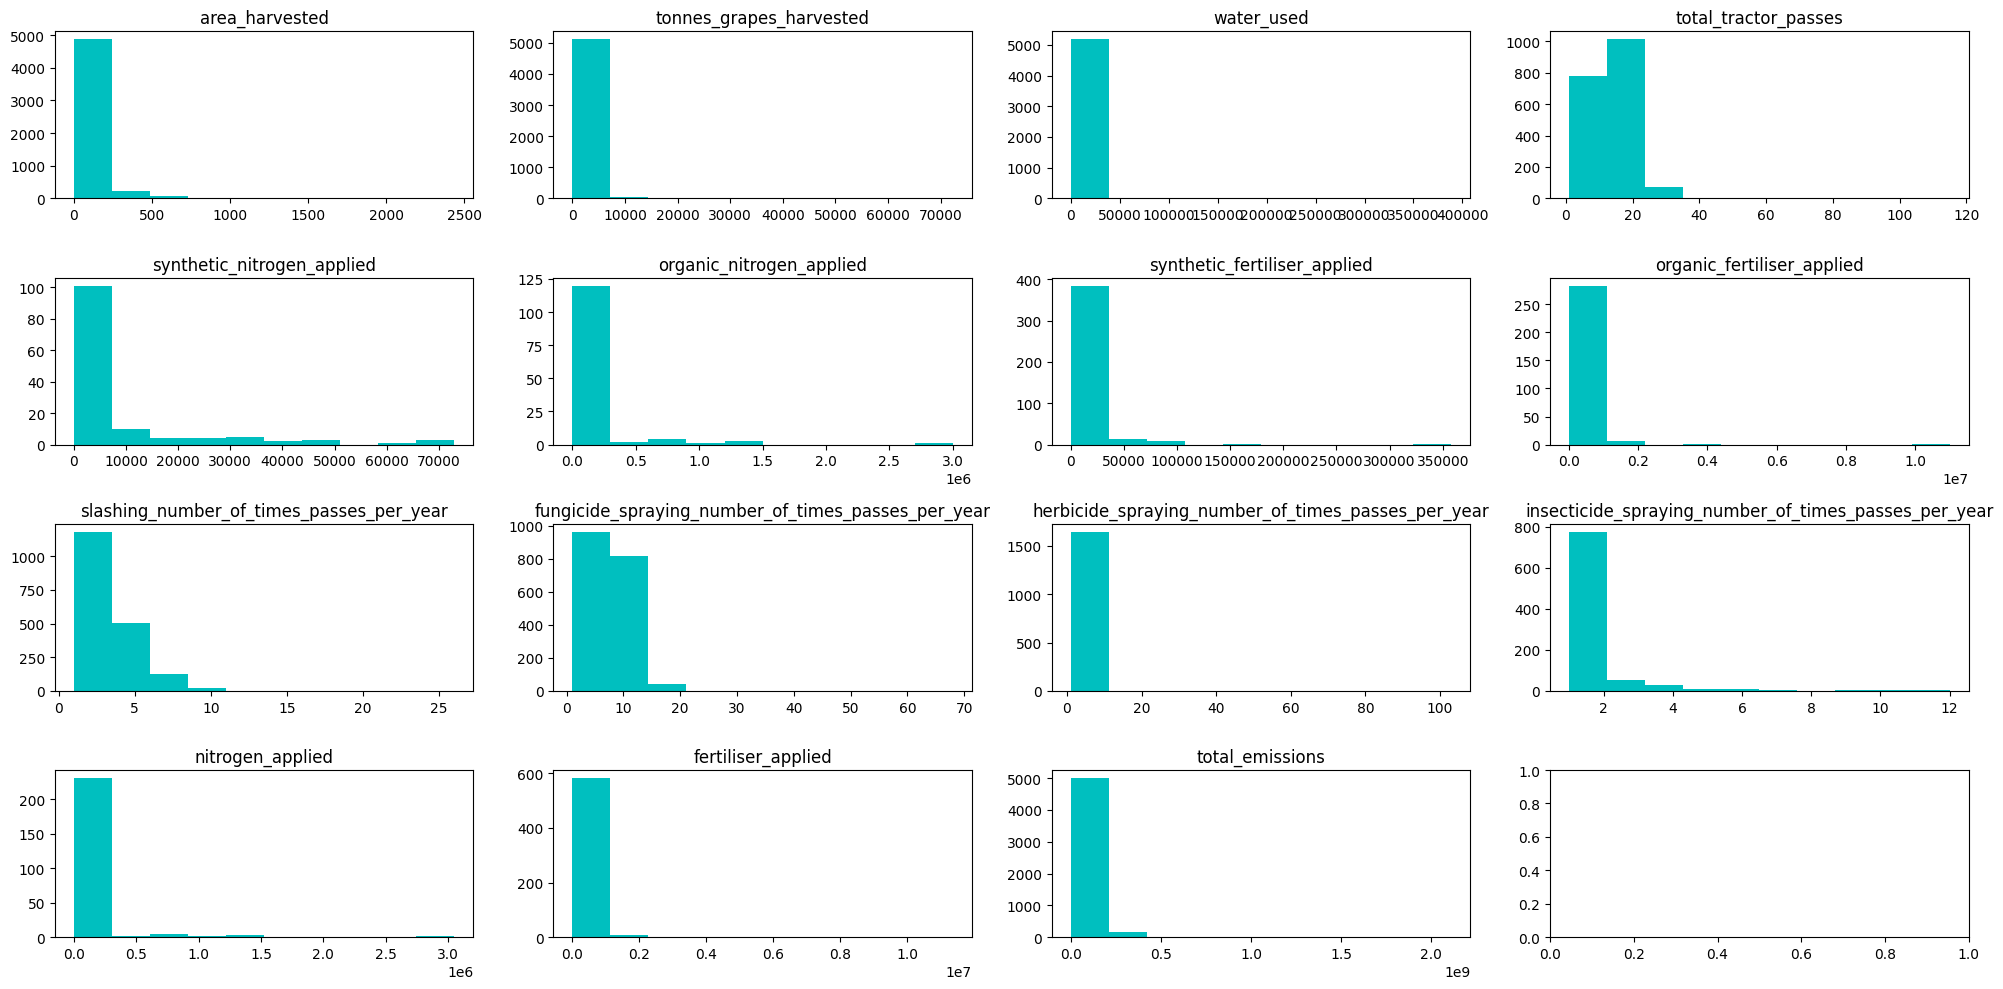

In [128]:
multihist(df[feature_list])
plt.tight_layout()

There are notably two problems with this data. It is skewed due to there being more smalelr wineries than larger, and that there are a few outliers that are likely due to user error. We remove the top and bottom ends and this fixes it.

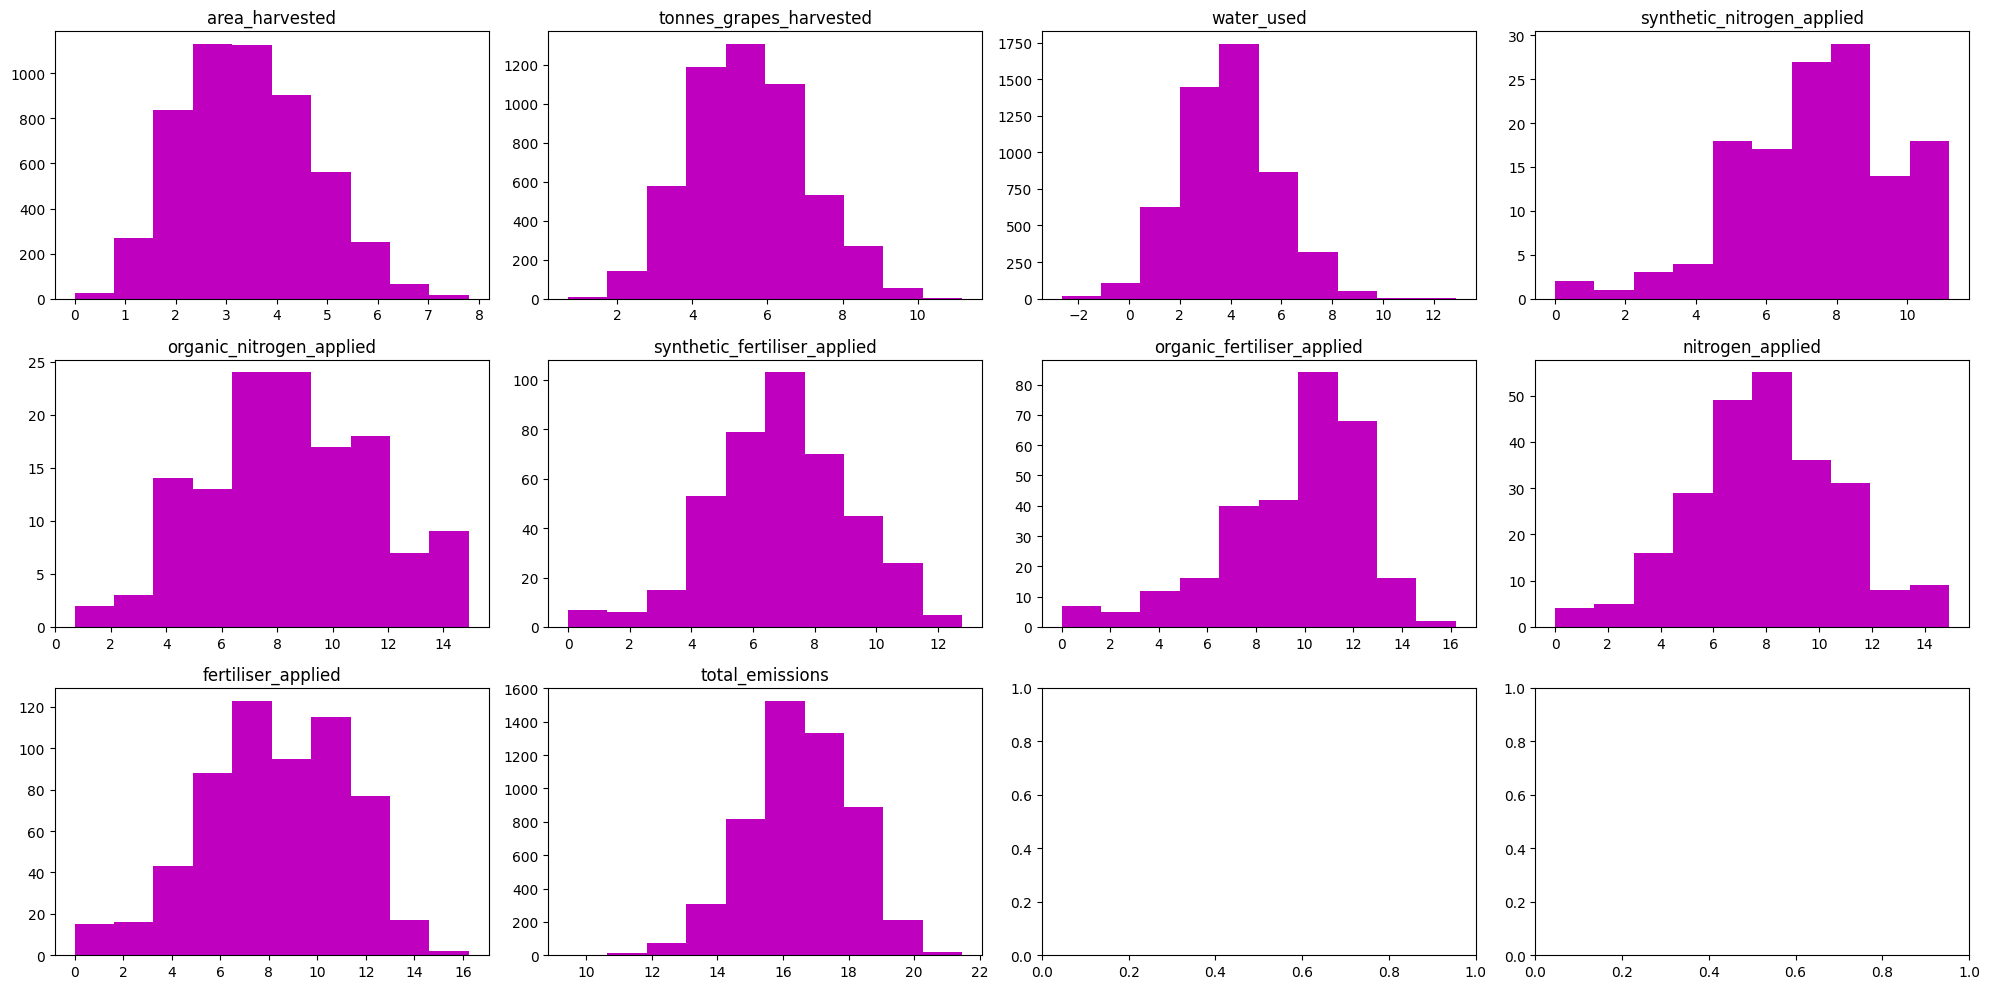

In [129]:
#If values graphed below are overwhelming large then a random error has occurred. Rerun the cell until the dissapear.
fig, ax = multihist(df[[
    "area_harvested"
    , "tonnes_grapes_harvested"
    , "water_used"
    , "synthetic_nitrogen_applied"
    , "organic_nitrogen_applied"
    , "synthetic_fertiliser_applied"
    , "organic_fertiliser_applied"
    , "nitrogen_applied"
    , "fertiliser_applied"
    , "total_emissions"
]].apply(np.log), color="m")
plt.tight_layout()

In [130]:
df['tonnes_grapes_harvested'].div(df["area_harvested"]).describe()

count    5189.000000
mean       10.324662
std         7.949191
min         0.754497
25%         5.217391
50%         7.512195
75%        12.163952
max        71.444444
dtype: float64

In [131]:
len(feature_list)

15

### GLM Baseline

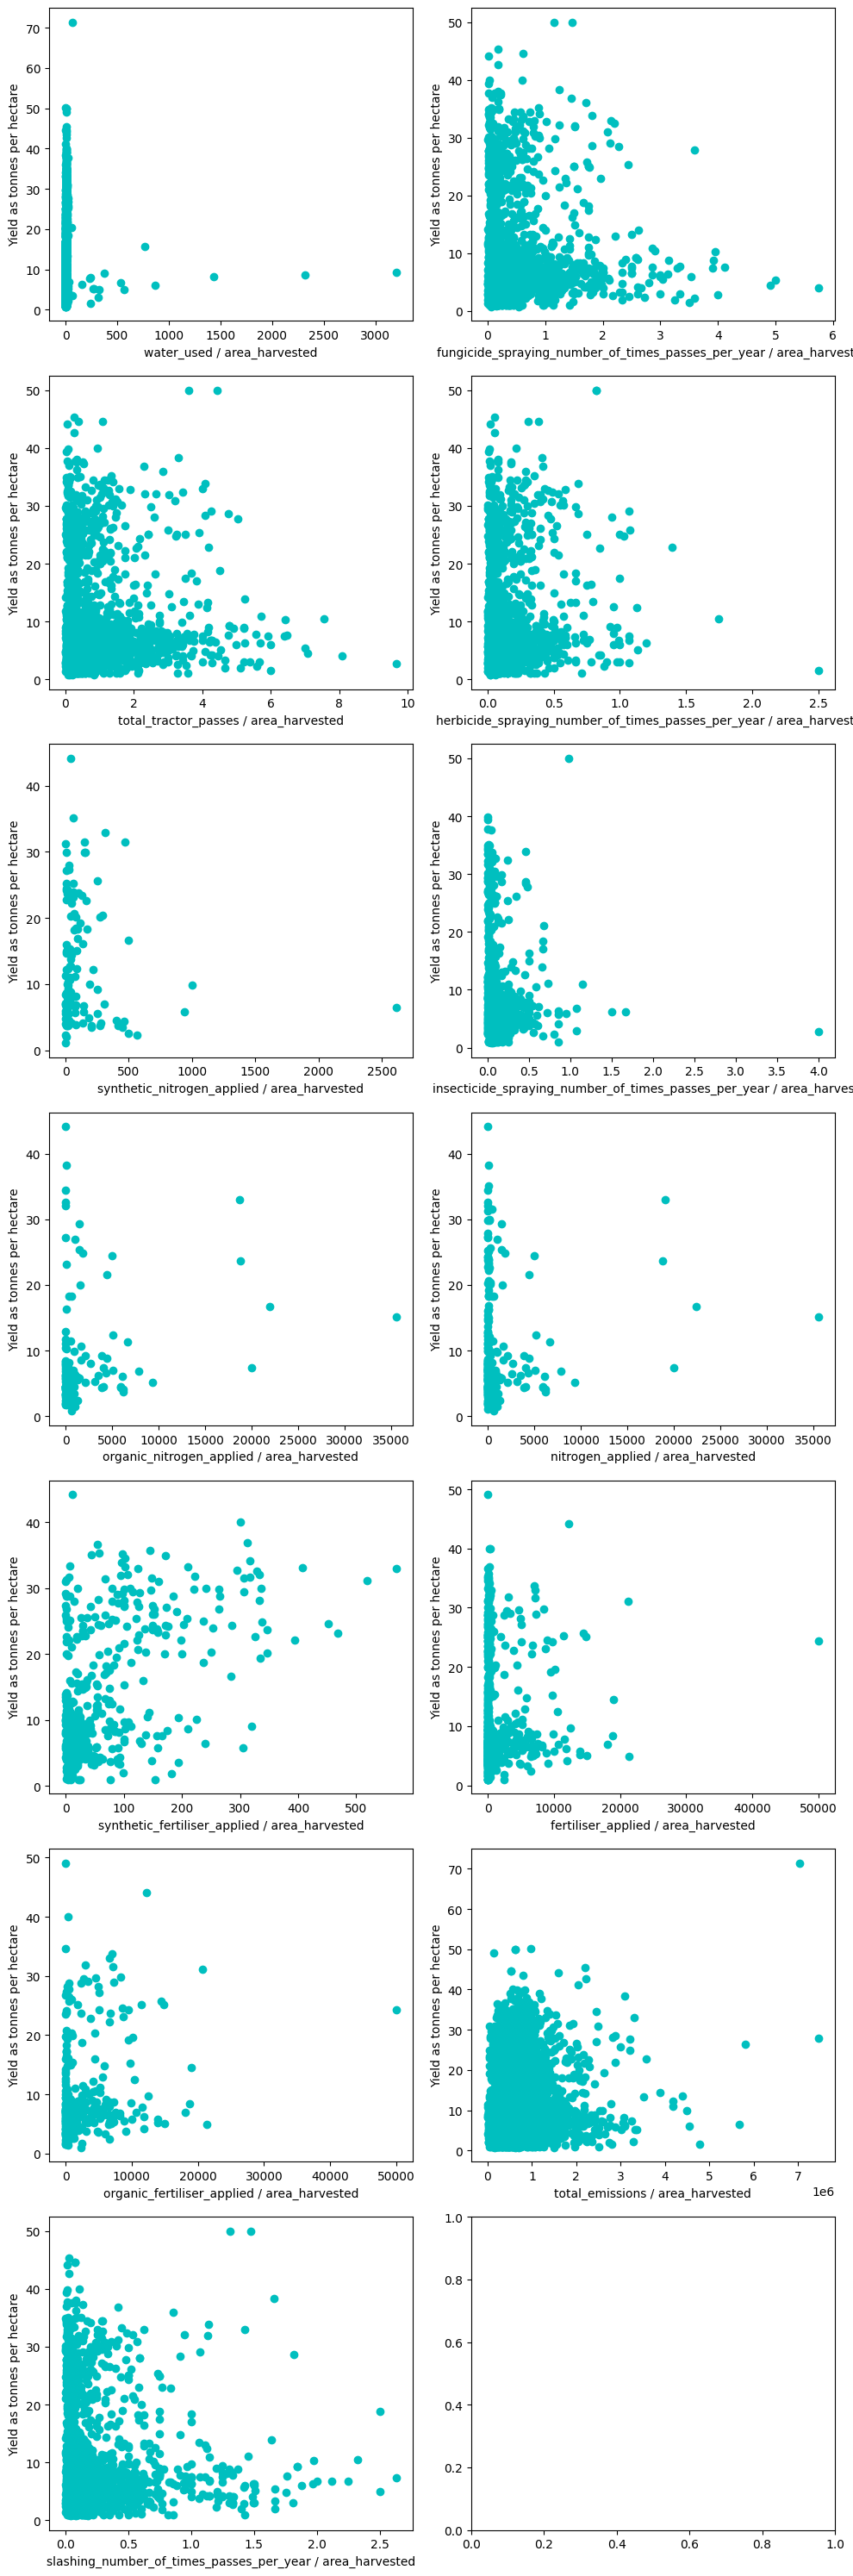

In [132]:
rows = int(round((len(feature_list))/2))-1
cols = 2

fig, ax = plt.subplots(rows, cols, figsize=(10, 30))

i = 0
j = 0
for feature in feature_list:
    if feature == 'tonnes_grapes_harvested':
        continue
    if feature == 'area_harvested':
        continue
    ax[i][j].scatter(df[feature].div(df["area_harvested"]),
                  df['tonnes_grapes_harvested'].div(df["area_harvested"]), color="c")
    ax[i][j].set_xlabel("{} / area_harvested".format(feature))
    ax[i][j].set_ylabel("Yield as tonnes per hectare")
    i += 1
    if i == rows:
        j+=1
        i=0

#fig.text(-0.01, 0.5, "Yield as tonnes per hectare", va="center", rotation='vertical')
fig.tight_layout()
plt.show()

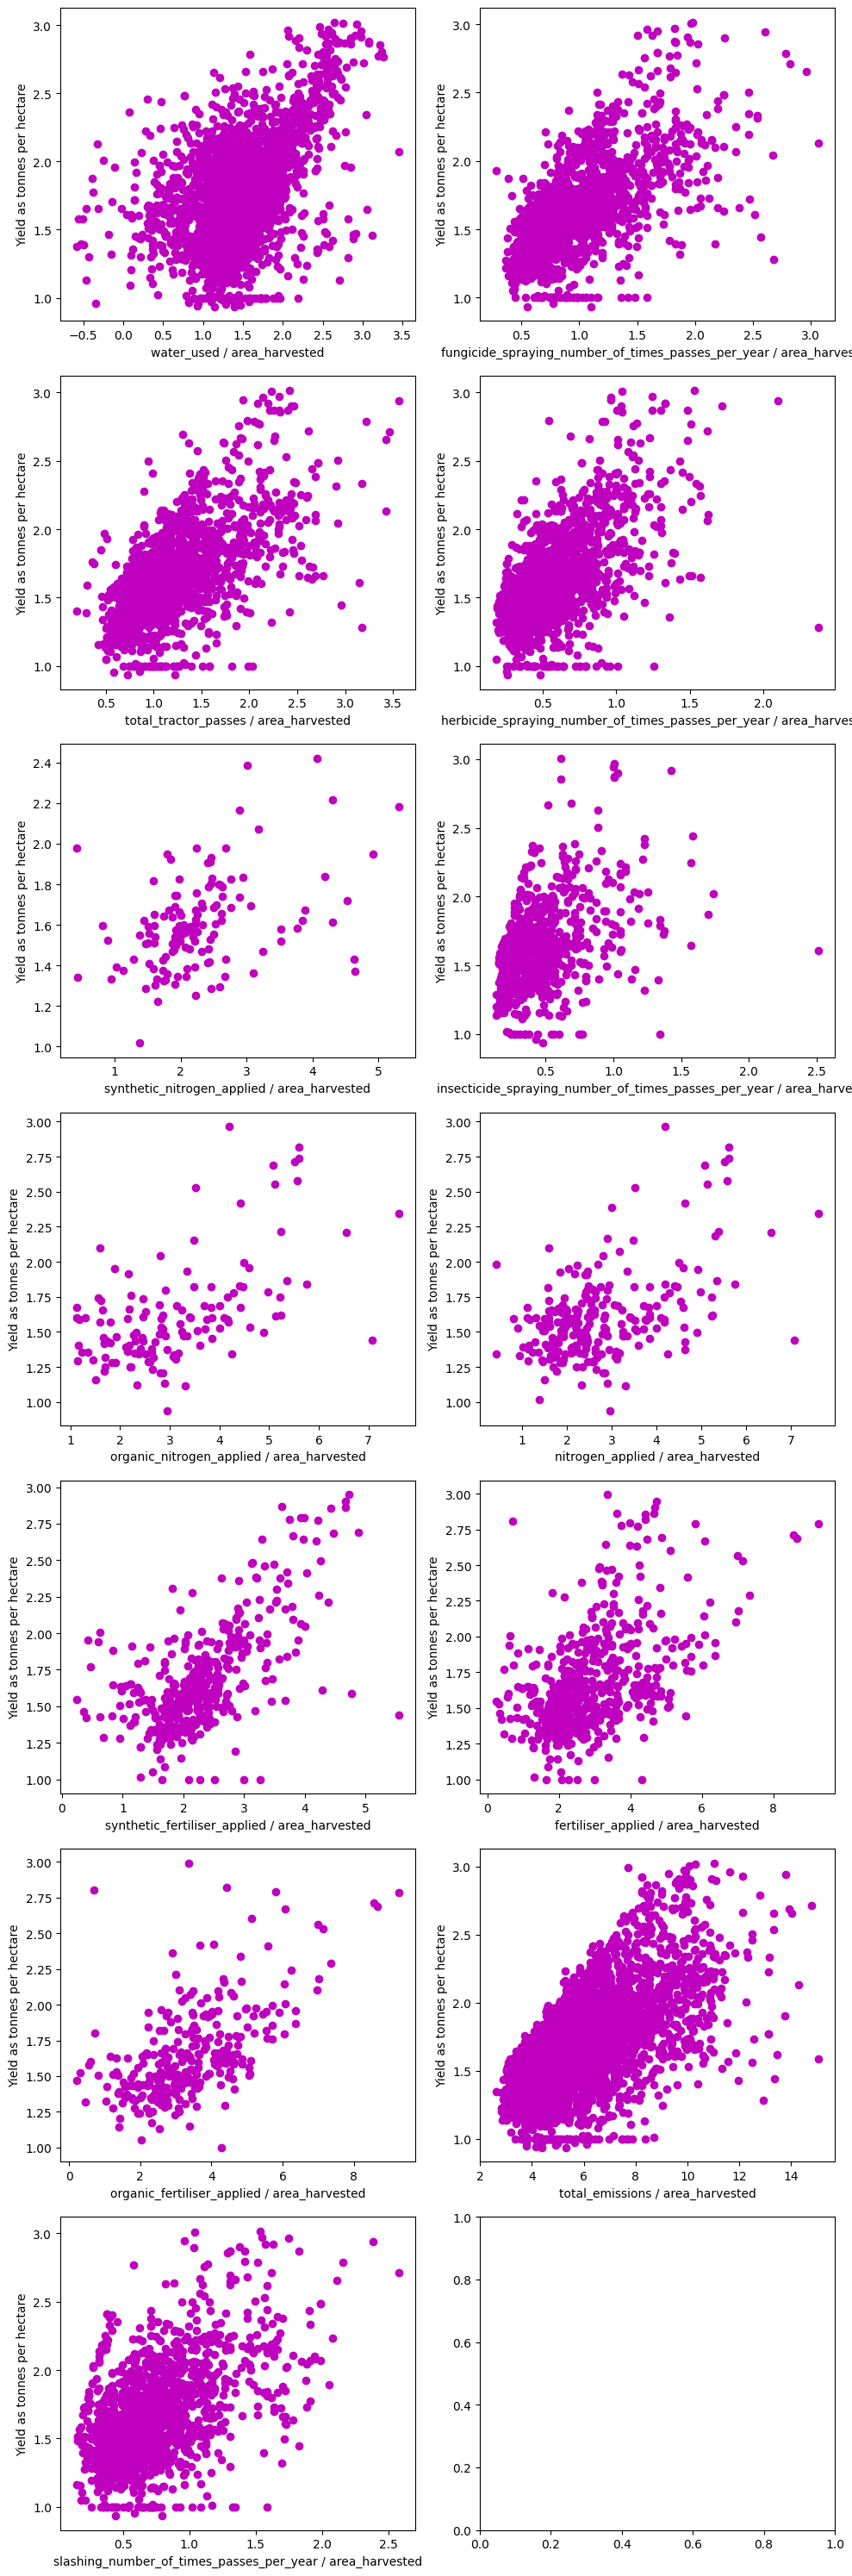

In [133]:
rows = int(round((len(feature_list))/2))-1
cols = 2

fig, ax = plt.subplots(rows, cols, figsize=(10, 30))

i = 0
j=0
for feature in feature_list:
    if feature == 'tonnes_grapes_harvested':
        continue
    if feature == 'area_harvested':
        continue 
    ax[i][j].scatter((1+df[feature].apply(np.log)).div((1+df["area_harvested"]).apply(np.log))
                  , (1+df['tonnes_grapes_harvested']).apply(np.log).div((1+df["area_harvested"]).apply(np.log))
                  , color="m")
    ax[i][j].set_xlabel("{} / area_harvested".format(feature))
    ax[i][j].set_ylabel("Yield as tonnes per hectare")
    i += 1
    if i == rows:
        j+=1
        i=0
        
#fig.text(0.04, 0.5, "Yield", ha="center", rotation='vertical')
fig.tight_layout()
plt.show()

In [134]:
df[feature_list].replace({np.nan: 0})["nitrogen_applied"].describe()

count    5.189000e+03
mean     3.168647e+03
std      6.010650e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.050000e+06
Name: nitrogen_applied, dtype: float64

In [135]:
rpy2.ipython.html.init_printing()
r = robjects.r

df[feature_list].replace({np.nan: 0}).to_csv("data.csv")

r.source("linear_model.r")
r.linear_model("data.csv", "(df$tonnes_grapes_harvested)/(df$area_harvested)"
    "~ (df$total_emissions)/(df$area_harvested)"
    "+ (df$water_used)/(df$area_harvested) "
    "+ (df$total_tractor_passes)"
    "+ (df$synthetic_nitrogen_applied)/(df$area_harvested)"
    "+ (df$organic_nitrogen_applied)/(df$area_harvested)"
    "+ (df$synthetic_fertiliser_applied)/(df$area_harvested)"
    "+ (df$organic_fertiliser_applied)/(df$area_harvested)"
    "+ (df$slashing_number_of_times_passes_per_year)"
    "+ (df$fungicide_spraying_number_of_times_passes_per_year)"
    "+ (df$herbicide_spraying_number_of_times_passes_per_year)"
    "+ (df$insecticide_spraying_number_of_times_passes_per_year)"
    "+ (df$nitrogen_applied)/(df$area_harvested)"
    "+ (df$fertiliser_applied)/(df$area_harvested)"
)


***************
*    ANOVA    *

Analysis of Deviance Table

Model: gaussian, link: identity

Response: (df$tonnes_grapes_harvested)/(df$area_harvested)

Terms added sequentially (first to last)


                                                        Df Deviance Resid. Df
NULL                                                                     5188
df$total_emissions                                       1   3551.2      5187
df$water_used                                            1     70.3      5186
df$total_tractor_passes                                  1    205.7      5185
df$synthetic_nitrogen_applied                            1    891.8      5184
df$organic_nitrogen_applied                              1    306.7      5183
df$synthetic_fertiliser_applied                          1   3291.4      5182
df$organic_fertiliser_applied                            1    171.0      5181
df$slashing_number_of_times_passes_per_year              1    506.1      5180
df$fungicide_spraying_

df$total_emissions:df$area_harvested                     -5.065 0.000000422307
df$area_harvested:df$water_used                           2.045         0.0409
df$area_harvested:df$synthetic_nitrogen_applied          -0.160         0.8732
df$area_harvested:df$organic_nitrogen_applied             1.303         0.1926
df$area_harvested:df$synthetic_fertiliser_applied        -6.242 0.000000000467
df$area_harvested:df$organic_fertiliser_applied           2.171         0.0300
                                                           
(Intercept)                                             ***
df$total_emissions                                      ***
df$water_used                                              
df$total_tractor_passes                                    
df$synthetic_nitrogen_applied                              
df$organic_nitrogen_applied                                
df$synthetic_fertiliser_applied                         ***
df$organic_fertiliser_applied                 

<rpy2.robjects.vectors.ListVector object at 0x7f6af2164bc0> [RTYPES.VECSXP]
R classes: ('glm', 'lm')
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., ListSexpV..., StrSexpVe..., NULLType, ListSexpV...]
  coefficients: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7f6b19789800> [RTYPES.REALSXP]
R classes: ('numeric',)
[9.564966, 0.000000, -0.000030, -3.971194, ..., -0.000000, 0.000000,      nan,      nan]
  residuals: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7f6af31c8500> [RTYPES.REALSXP]
R classes: ('numeric',)
[-5.997065, -2.700189, -0.204615, -5.861782, ..., -6.574761, -3.575109, -6.296054, -3.229954]
  fitted.values: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7f6b6a587d00> [RTYPES.REALSXP]
R classes: ('numeric',)
[9.608219, 9.420189, 9.579615, 9.579731, ..., 9.574761, 9.575109, 9.296054, 9.623288]
  effects: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7f6af2170680> [RTYPES.REALSXP]
R classes: ('numeric',)
[-743.734085, 59.591551, 8.382871, 14.343481, ..., -6.386292, -3.386676, -5.969100, -3.046843]
...
<rpy2.robjects.vectors.ListVector object at 0x7f6af2164bc0> [RTYPES.VECSXP]
R classes: ('glm', 'lm')
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., ListSexpV..., StrSexpVe..., NULLType, ListSexpV...]
  qr: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7f6af2164fc0> [RTYPES.STRSXP]
R classes: ('character',)
['glm.fit']
  family: <class 'rpy2.rinterface_lib.sexp.NULLType'>
  <rpy2.rinterface_lib.sexp.NULLType object at 0x7f6b6d78c400> [RTYPES.NILSXP]
<rpy2.robjects.vectors.ListVector object at 0x7f6af2164bc0> [RTYPES.VECSXP]
R classes: ('glm', 'lm')
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., ListSexpV..., StrSexpVe..., NULLType, ListSexpV...]

In [136]:
rpy2.ipython.html.init_printing()
r = robjects.r

df[feature_list].replace({np.nan: 0}).to_csv("data.csv")

r.source("linear_model.r")
r.linear_model("data.csv", "log(df$tonnes_grapes_harvested+1)/log(df$area_harvested+1)"
    "~ log(df$total_emissions+1)/log(df$area_harvested+1)"
    "+ log(df$water_used+1)/log(df$area_harvested+1) "
    "+ (df$total_tractor_passes)"
    "+ log(df$synthetic_nitrogen_applied+1)/log(df$area_harvested+1)"
    "+ log(df$organic_nitrogen_applied+1)/log(df$area_harvested+1)"
    "+ log(df$synthetic_fertiliser_applied+1)/log(df$area_harvested+1)"
    "+ log(df$organic_fertiliser_applied+1)/log(df$area_harvested+1)"
    "+ (df$slashing_number_of_times_passes_per_year)"
    "+ (df$fungicide_spraying_number_of_times_passes_per_year)"
    "+ (df$herbicide_spraying_number_of_times_passes_per_year)"
    "+ (df$insecticide_spraying_number_of_times_passes_per_year)"
    "+ log(df$nitrogen_applied+1)/log(df$area_harvested+1)"
    "+ log(df$fertiliser_applied+1)/log(df$area_harvested+1)"
)


***************
*    ANOVA    *

Analysis of Deviance Table

Model: gaussian, link: identity

Response: log(df$tonnes_grapes_harvested + 1)/log(df$area_harvested + 1)

Terms added sequentially (first to last)


                                                                    Df Deviance
NULL                                                                           
log(df$total_emissions + 1)                                          1  116.868
log(df$water_used + 1)                                               1    7.087
df$total_tractor_passes                                              1    0.218
log(df$synthetic_nitrogen_applied + 1)                               1    0.048
log(df$organic_nitrogen_applied + 1)                                 1    0.186
log(df$synthetic_fertiliser_applied + 1)                             1    3.118
log(df$organic_fertiliser_applied + 1)                               1    0.010
df$slashing_number_of_times_passes_per_year                         

log(df$organic_fertiliser_applied + 1)                               0.0119626
df$slashing_number_of_times_passes_per_year                          0.1040865
df$fungicide_spraying_number_of_times_passes_per_year                0.1039972
df$herbicide_spraying_number_of_times_passes_per_year                0.1039081
df$insecticide_spraying_number_of_times_passes_per_year              0.1037778
log(df$nitrogen_applied + 1)                                         0.0269705
log(df$fertiliser_applied + 1)                                       0.0141879
log(df$total_emissions + 1):log(df$area_harvested + 1)               0.0006133
log(df$area_harvested + 1):log(df$water_used + 1)                    0.0016876
log(df$area_harvested + 1):log(df$synthetic_nitrogen_applied + 1)    0.0057351
log(df$area_harvested + 1):log(df$organic_nitrogen_applied + 1)      0.0056700
log(df$area_harvested + 1):log(df$synthetic_fertiliser_applied + 1)  0.0030764
log(df$area_harvested + 1):log(df$organic_fertiliser

                                                       -0.023781349 
                  log(df$area_harvested + 1):log(df$water_used + 1) 
                                                        0.028994866 
  log(df$area_harvested + 1):log(df$synthetic_nitrogen_applied + 1) 
                                                        0.007234593 
    log(df$area_harvested + 1):log(df$organic_nitrogen_applied + 1) 
                                                       -0.001941508 
log(df$area_harvested + 1):log(df$synthetic_fertiliser_applied + 1) 
                                                        0.001369604 
  log(df$area_harvested + 1):log(df$organic_fertiliser_applied + 1) 
                                                        0.004992110 
            log(df$area_harvested + 1):log(df$nitrogen_applied + 1) 
                                                        0.000363220 
          log(df$area_harvested + 1):log(df$fertiliser_applied + 1) 
                                  

<rpy2.robjects.vectors.ListVector object at 0x7f6af2084bc0> [RTYPES.VECSXP]
R classes: ('glm', 'lm')
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., ListSexpV..., StrSexpVe..., NULLType, ListSexpV...]
  coefficients: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7f6af2086b80> [RTYPES.REALSXP]
R classes: ('numeric',)
[1.125165, 0.090047, -0.002330, -0.066590, ..., 0.001370, 0.004992, 0.000363, -0.007720]
  residuals: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7f6af22472c0> [RTYPES.REALSXP]
R classes: ('numeric',)
[-0.196248, 0.212053, 0.223906, -0.210370, ..., -0.253718, 0.309092, -0.240595, 0.054006]
  fitted.values: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7f6af2267940> [RTYPES.REALSXP]
R classes: ('numeric',)
[1.577602, 1.915157, 1.747096, 1.774317, ..., 2.024962, 2.025625, 2.011839, 2.113421]
  effects: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7f6af216a400> [RTYPES.REALSXP]
R classes: ('numeric',)
[-118.754167, -10.810569, 2.662180, 0.467389, ..., -0.242917, 0.320310, -0.232369, 0.083021]
...
<rpy2.robjects.vectors.ListVector object at 0x7f6af2084bc0> [RTYPES.VECSXP]
R classes: ('glm', 'lm')
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., ListSexpV..., StrSexpVe..., NULLType, ListSexpV...]
  qr: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7f6b296baec0> [RTYPES.STRSXP]
R classes: ('character',)
['glm.fit']
  family: <class 'rpy2.rinterface_lib.sexp.NULLType'>
  <rpy2.rinterface_lib.sexp.NULLType object at 0x7f6b6d78c400> [RTYPES.NILSXP]
<rpy2.robjects.vectors.ListVector object at 0x7f6af2084bc0> [RTYPES.VECSXP]
R classes: ('glm', 'lm')
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., ListSexpV..., StrSexpVe..., NULLType, ListSexpV...]

In [137]:
rpy2.ipython.html.init_printing()
r = robjects.r

df[feature_list].replace({np.nan: 0}).to_csv("data.csv")

r.source("linear_model.r")
r.linear_model("data.csv", "log(df$tonnes_grapes_harvested+1)/log(df$area_harvested+1)"
    "~ log(df$total_emissions+1)/log(df$area_harvested+1)"
    "+ log(df$water_used+1)/log(df$area_harvested+1) "
    "+ log(df$water_used+1)/log(df$area_harvested+1)"
    "+ log(df$fertiliser_applied + 1)"
)


***************
*    ANOVA    *

Analysis of Deviance Table

Model: gaussian, link: identity

Response: log(df$tonnes_grapes_harvested + 1)/log(df$area_harvested + 1)

Terms added sequentially (first to last)


                                                       Df Deviance Resid. Df
NULL                                                                    5188
log(df$total_emissions + 1)                             1  116.868      5187
log(df$water_used + 1)                                  1    7.087      5186
log(df$fertiliser_applied + 1)                          1    1.318      5185
log(df$total_emissions + 1):log(df$area_harvested + 1)  1  104.099      5184
log(df$area_harvested + 1):log(df$water_used + 1)       1   14.960      5183
                                                       Resid. Dev
NULL                                                       510.15
log(df$total_emissions + 1)                                393.28
log(df$water_used + 1)                             

<rpy2.robjects.vectors.ListVector object at 0x7f6b2ba34bc0> [RTYPES.VECSXP]
R classes: ('glm', 'lm')
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., ListSexpV..., StrSexpVe..., NULLType, ListSexpV...]
  coefficients: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7f6b6010f080> [RTYPES.REALSXP]
R classes: ('numeric',)
[1.132027, 0.088997, 0.002088, 0.004054, -0.023822, 0.028473]
  residuals: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7f6af21b7c80> [RTYPES.REALSXP]
R classes: ('numeric',)
[-0.193461, 0.196995, 0.227559, -0.207840, ..., -0.251191, 0.311854, -0.251191, 0.144597]
  fitted.values: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7f6b2b94bf80> [RTYPES.REALSXP]
R classes: ('numeric',)
[1.574815, 1.930215, 1.743443, 1.771788, ..., 2.022435, 2.022863, 2.022435, 2.022831]
  effects: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x7f6af291a0c0> [RTYPES.REALSXP]
R classes: ('numeric',)
[-118.754167, -10.810569, 2.662180, 1.148039, ..., -0.248185, 0.314939, -0.248185, 0.143515]
...
<rpy2.robjects.vectors.ListVector object at 0x7f6b2ba34bc0> [RTYPES.VECSXP]
R classes: ('glm', 'lm')
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., ListSexpV..., StrSexpVe..., NULLType, ListSexpV...]
  qr: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7f6af21aec40> [RTYPES.STRSXP]
R classes: ('character',)
['glm.fit']
  family: <class 'rpy2.rinterface_lib.sexp.NULLType'>
  <rpy2.rinterface_lib.sexp.NULLType object at 0x7f6b6d78c400> [RTYPES.NILSXP]
<rpy2.robjects.vectors.ListVector object at 0x7f6b2ba34bc0> [RTYPES.VECSXP]
R classes: ('glm', 'lm')
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., ListSexpV..., StrSexpVe..., NULLType, ListSexpV...]

In [138]:
rpy2.ipython.html.init_printing()
r = robjects.r

df.to_csv("data.csv")

r.source("linear_model.r")
model = r.linear_model("data.csv", "log(df$tonnes_grapes_harvested+1)/log(df$area_harvested+1)"
    "~ log(df$total_emissions+1)/log(df$area_harvested+1) "
    "+ log(df$water_used+1)/log(df$area_harvested+1) "
)


***************
*    ANOVA    *

Analysis of Deviance Table

Model: gaussian, link: identity

Response: log(df$tonnes_grapes_harvested + 1)/log(df$area_harvested + 1)

Terms added sequentially (first to last)


                                                       Df Deviance Resid. Df
NULL                                                                    5188
log(df$total_emissions + 1)                             1  116.868      5187
log(df$water_used + 1)                                  1    7.087      5186
log(df$total_emissions + 1):log(df$area_harvested + 1)  1  104.648      5185
log(df$area_harvested + 1):log(df$water_used + 1)       1   15.061      5184
                                                       Resid. Dev
NULL                                                       510.15
log(df$total_emissions + 1)                                393.28
log(df$water_used + 1)                                     386.20
log(df$total_emissions + 1):log(df$area_harvested + 1)     281

In [139]:
model[4]

<rpy2.robjects.vectors.FloatMatrix object at 0x7f6af22c5500> [RTYPES.REALSXP]
R classes: ('matrix', 'array')
[-72.034714, 0.000000, 0.000000, 0.000000, ..., 639.906107, 437.663639, -207.404965, -135.858041]

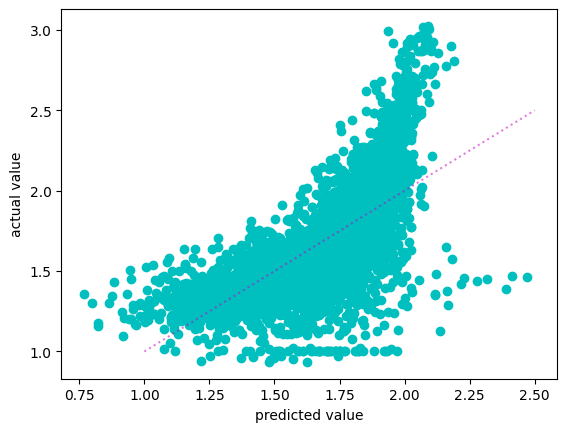

In [140]:
fig, ax = plt.subplots()

plt.plot([1,2.5], [1,2.5], color='m', linestyle='dotted', alpha=0.5)
plt.scatter(model[2]
    , model[17]
    , color="c")

plt.xlabel("predicted value")
plt.ylabel("actual value")

plt.show()    

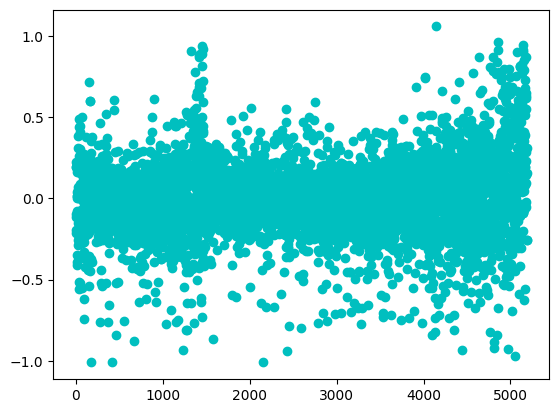

In [141]:
residuals = model[1]
plt.scatter(range(len(residuals)), residuals, color="c")

In [142]:
np.std(np.array(residuals))

0.22661935477950554

In [143]:
np.max(np.array(residuals))

1.0583974543654318

In [144]:
np.min(np.array(residuals))

-1.0099268327939075

(array([   9.,   11.,   27.,   32.,   49.,   92.,  158.,  431.,  811.,
        1250., 1183.,  578.,  253.,  128.,   74.,   38.,   25.,   22.,
          16.,    2.]),
 array([-1.00992683, -0.90651062, -0.8030944 , -0.69967819, -0.59626198,
        -0.49284576, -0.38942955, -0.28601333, -0.18259712, -0.0791809 ,
         0.02423531,  0.12765153,  0.23106774,  0.33448395,  0.43790017,
         0.54131638,  0.6447326 ,  0.74814881,  0.85156503,  0.95498124,
         1.05839745]),
 <BarContainer object of 20 artists>)

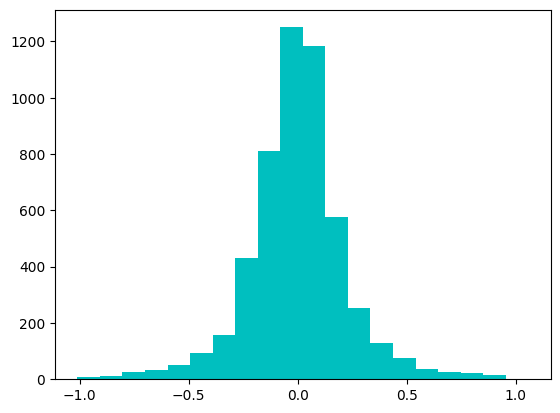

In [145]:
plt.hist(residuals, bins=20, color="c")

In [146]:
from scipy.stats import shapiro

shapiro(residuals)

/home/bryce/repositories/paper_one/venv/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.955986738204956, pvalue=5.844301562110466e-37)

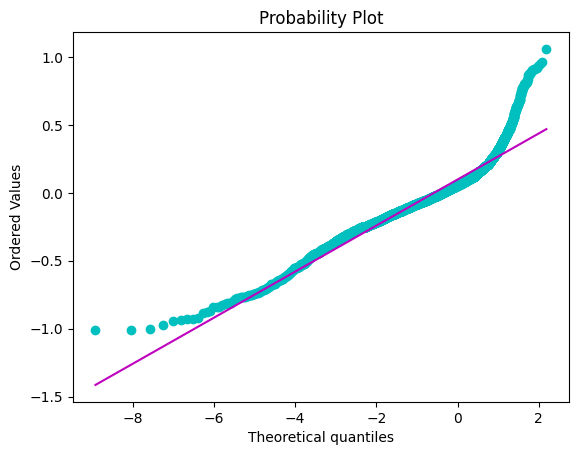

In [147]:
from scipy import stats



fig, ax = plt.subplots()

stats.probplot(
    residuals
    , dist=stats.loggamma
    , sparams=(1)
    , plot=ax
)
ax.get_lines()[0].set_color("c")
ax.get_lines()[1].set_color("m")

plt.show()    

### ???

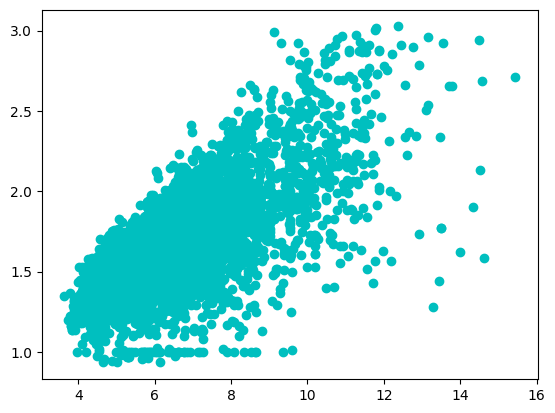

In [148]:
df["water_and_emmissions"] = (1+df["water_used"]).apply(np.log).div((1+df["area_harvested"]).apply(np.log)) +\
            ((1+df["total_emissions"]).apply(np.log).div((1+df["area_harvested"]).apply(np.log)))
df["yield"] = (1+df['tonnes_grapes_harvested']).apply(np.log).div((1+df["area_harvested"]).apply(np.log))

plt.scatter(df["water_and_emmissions"], df["yield"], color="c")


plt.show()

### MA Cluster

In [149]:
df

field  member_id data_year_id  vineyard_area  area_harvested  \
3351         641    2013/2014          26.00           26.00   
5043        1152    2020/2021           3.50            3.50   
3116         588    2016/2017           8.00            8.00   
2033         371    2012/2013           7.80            7.80   
671          110    2013/2014         650.00          650.00   
...          ...          ...            ...             ...   
1949         352    2018/2019           4.85            4.85   
3383         646    2020/2021           2.00            2.00   
3491         668    2017/2018           2.84            2.00   
3384         646    2021/2022           2.00            2.00   
5022        1124    2018/2019           3.00            3.00   

field  tonnes_grapes_harvested  water_used  total_tractor_passes  \
3351                     93.89      18.747                   NaN   
5043                     23.52       3.000                  14.0   
3116                     75.00       4.000                   NaN   
2033                     29.00       6.000                   NaN   
671                    2072.00    1498.000                   NaN   
...                        ...         ...                   ...   
1949                    110.00      42.000                   NaN   
3383                      6.00       3.000                   NaN   
3491                     12.00       2.800                   NaN   
3384                      6.00       3.000                   6.0   
5022                     19.18       1.821                   NaN   

field  total_vineyard_fuel  total_vineyard_electricity  total_irrigation_area  \
3351                 900.0                      10.008                  22.40   
5043                 300.0                       3.000                   3.50   
3116                 300.0                       5.000                   8.00   
2033                 300.0                       5.000                   7.80   
671                43736.0                     121.400                 330.00   
...                    ...                         ...                    ...   
1949                5000.0                         NaN                   4.85   
3383                 200.0                         NaN                   2.00   
3491                 200.0                         NaN                   2.84   
3384                 200.0                         NaN                   2.00   
5022                 807.0                         NaN                   3.00   

field  ...  operating_cost_per_ha  operating_cost_per_t  nitrogen_applied  \
3351   ...                    NaN                   NaN               NaN   
5043   ...                    NaN                   NaN               NaN   
3116   ...                    NaN                   NaN               NaN   
2033   ...                    NaN                   NaN               NaN   
671    ...                    NaN                   NaN               NaN   
...    ...                    ...                   ...               ...   
1949   ...                    NaN                   NaN               NaN   
3383   ...                    NaN                   NaN               NaN   
3491   ...                    NaN                   NaN               NaN   
3384   ...                    NaN                   NaN               NaN   
5022   ...                    NaN                   NaN               NaN   

field  fertiliser_applied  use_renewable    scope2        scope1  \
3351                  NaN            NaN  0.006805  3.080135e+06   
5043                  NaN            1.0  0.007140  1.026712e+06   
3116                  NaN            1.0  0.010880  1.026712e+06   
2033                  NaN            NaN  0.003400  1.038570e+06   
671                   NaN            NaN  0.082552  1.499313e+08   
...                   ...            ...       ...           ...   
1949                  NaN            NaN

In [150]:
X = df[feature_list].replace({np.nan: 0}).to_numpy()
X

array([[2.60000000e+01, 9.38900000e+01, 1.87470000e+01, ...,
        0.00000000e+00, 0.00000000e+00, 3.08013526e+06],
       [3.50000000e+00, 2.35200000e+01, 3.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.02671176e+06],
       [8.00000000e+00, 7.50000000e+01, 4.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.02671176e+06],
       ...,
       [2.00000000e+00, 1.20000000e+01, 2.80000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 7.08191854e+05],
       [2.00000000e+00, 6.00000000e+00, 3.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 6.84474503e+05],
       [3.00000000e+00, 1.91800000e+01, 1.82100000e+00, ...,
        0.00000000e+00, 6.00000000e+01, 2.80596888e+06]])

In [151]:
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.5)

ms = MeanShift(bandwidth=bandwidth)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)


number of estimated clusters : 13


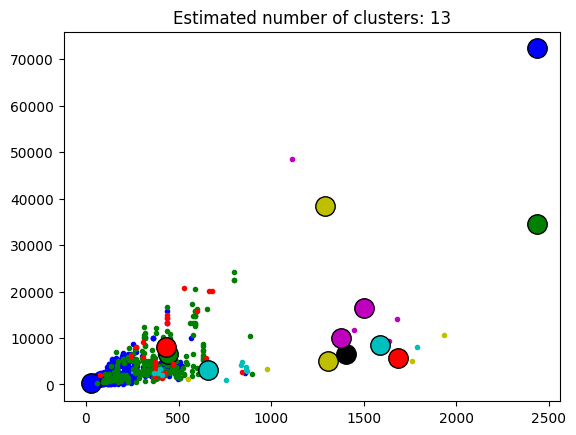

In [152]:
import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + ".")
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=14,
    )
plt.title("Estimated number of clusters: %d" % n_clusters_)
#plt.xlim([-10,2500])
#plt.ylim([-10,2000])
plt.show()

In [153]:
df["labels"] = labels
df.groupby("labels").describe()

field  member_id                                                              \
           count         mean          std     min      25%     50%      75%   
labels                                                                         
0         4899.0   633.509492   472.632388     1.0   266.00   546.0   889.00   
1          232.0   461.469828   509.600377     3.0   134.00   168.0   716.25   
2           29.0   330.827586   298.693353    22.0   134.00   137.0   716.00   
3           11.0   196.545455   108.224178   132.0   132.00   132.0   253.00   
4            6.0   205.666667   158.400337   141.0   141.00   141.0   141.00   
5            4.0   219.750000   163.555037   132.0   138.75   141.0   222.00   
6            2.0  1300.000000  1180.868325   465.0   882.50  1300.0  1717.50   
7            1.0  1315.000000          NaN  1315.0  1315.00  1315.0  1315.00   
8            1.0  1315.000000          NaN  1315.0  1315.00  1315.0  1315.00   
9            1.0   141.000000          NaN   141.0   141.00   141.0   141.00   
10           1.0   141.000000          NaN   141.0   141.00   141.0   141.00   
11           1.0   465.000000          NaN   465.0   465.00   465.0   465.00   
12           1.0   529.000000          NaN   529.0   529.00   529.0   529.00   

field          vineyard_area               ... water_and_emmissions  \
           max         count         mean  ...                  75%   
labels                                     ...                        
0       2187.0        4899.0    50.742827  ...             7.351622   
1       2076.0         232.0   378.143836  ...             4.735950   
2       1111.0          29.0   438.899310  ...             4.596439   
3        365.0          11.0   785.013636  ...             4.266667   
4        529.0           6.0  1553.333333  ...             3.919829   
5        465.0           4.0  1424.810000  ...             3.964569   
6       2135.0           2.0  1405.000000  ...             4.002744   
7       1315.0           1.0  2436.150000  ...             4.020262   
8       1315.0           1.0  2436.150000  ...             3.941277   
9        141.0           1.0  1685.000000  ...             3.820512   
10       141.0           1.0  1589.000000  ...             3.783668   
11       465.0           1.0  1376.000000  ...             4.042770   
12       529.0           1.0  1290.000000  ...             4.200269   

field               yield                                                    \
              max   count      mean       std       min       25%       50%   
labels                                                                        
0       15.439589  4899.0  1.662889  0.315308  0.934947  1.457851  1.606675   
1        5.911947   232.0  1.421447  0.124148  1.139081  1.332625  1.426165   
2        5.998811    29.0  1.440749  0.146755  1.170743  1.323486  1.429198   
3        4.407719    11.0  1.237606  0.084420  1.050945  1.198333  1.235210   
4        4.220142     6.0  1.295317  0.123506  1.202415  1.226384  1.260992   
5        4.310106     4.0  1.161918  0.049169  1.109926  1.131525  1.156946   
6        4.002744     2.0  1.214557  0.000000  1.214557  1.214557  1.214557   
7        4.020262     1.0  1.434704       NaN  1.434704  1.434704  1.434704   
8        3.941277     1.0  1.340112       NaN  1.340112  1.340112  1.340112   
9        3.820512     1.0  1.162542       NaN  1.162542  1.162542  1.162542   
10       3.783668     1.0  1.227136       NaN  1.227136  1.227136  1.227136   
11       4.042770     1.0  1.273416       NaN  1.273416  1.273416  1.273416   
12       4.200269     1.0  1.473989       NaN  1.473989  1.473989  1.473989   

field                       
             75%       max  
labels                      
0       1.816848  3.025081  
1       1.507809  1.744129  
2       1.571756  1.748512  
3       1.290177  1.355642  
4       1.286476  1.537686  
5       1.187339  1.223854  
6       1.214557  1.214557  
7       1.434704  1.434704 

In [154]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(df[feature_list].replace({np.nan: 0}))
for i in range(len(pca.explained_variance_ratio_)):
    print("{}: {}".format(feature_list[i], pca.explained_variance_ratio_[i]))
    print("{}: {}".format(feature_list[i], pca.singular_values_[i]))

area_harvested: 0.9999917283563985
area_harvested: 6335444577.179868
tonnes_grapes_harvested: 7.329250146150832e-06
tonnes_grapes_harvested: 17151758.945331175
water_used: 9.20731751067148e-07
water_used: 6079186.291169242
total_tractor_passes: 1.0590105027095932e-08
total_tractor_passes: 651972.1218659072
synthetic_nitrogen_applied: 9.527076005576748e-09
synthetic_nitrogen_applied: 618384.6592937157
organic_nitrogen_applied: 1.2793035874395184e-09
organic_nitrogen_applied: 226603.0239415605
synthetic_fertiliser_applied: 2.647903168966783e-10
synthetic_fertiliser_applied: 103093.18139226813
organic_fertiliser_applied: 4.188545728584705e-13
organic_fertiliser_applied: 4100.251751719329
slashing_number_of_times_passes_per_year: 9.76666160385084e-15
slashing_number_of_times_passes_per_year: 626.1119062231855
fungicide_spraying_number_of_times_passes_per_year: 3.967954677323131e-16
fungicide_spraying_number_of_times_passes_per_year: 126.20083943741714
herbicide_spraying_number_of_times_pas

In [155]:
region_selection = df.groupby("giregion").count()[(df.groupby("giregion").count()>50)["member_id"]].index.values

import matplotlib.cm as cm

region_color = {}
color = iter(cm.rainbow(np.linspace(0, 1, len(region_selection))))

for i in range(len(region_selection)):
   region_color[region_selection[i]] = i = next(color)

df['colors'] = df[df["giregion"].isin(region_selection)]["giregion"].apply(lambda x: region_color[x])

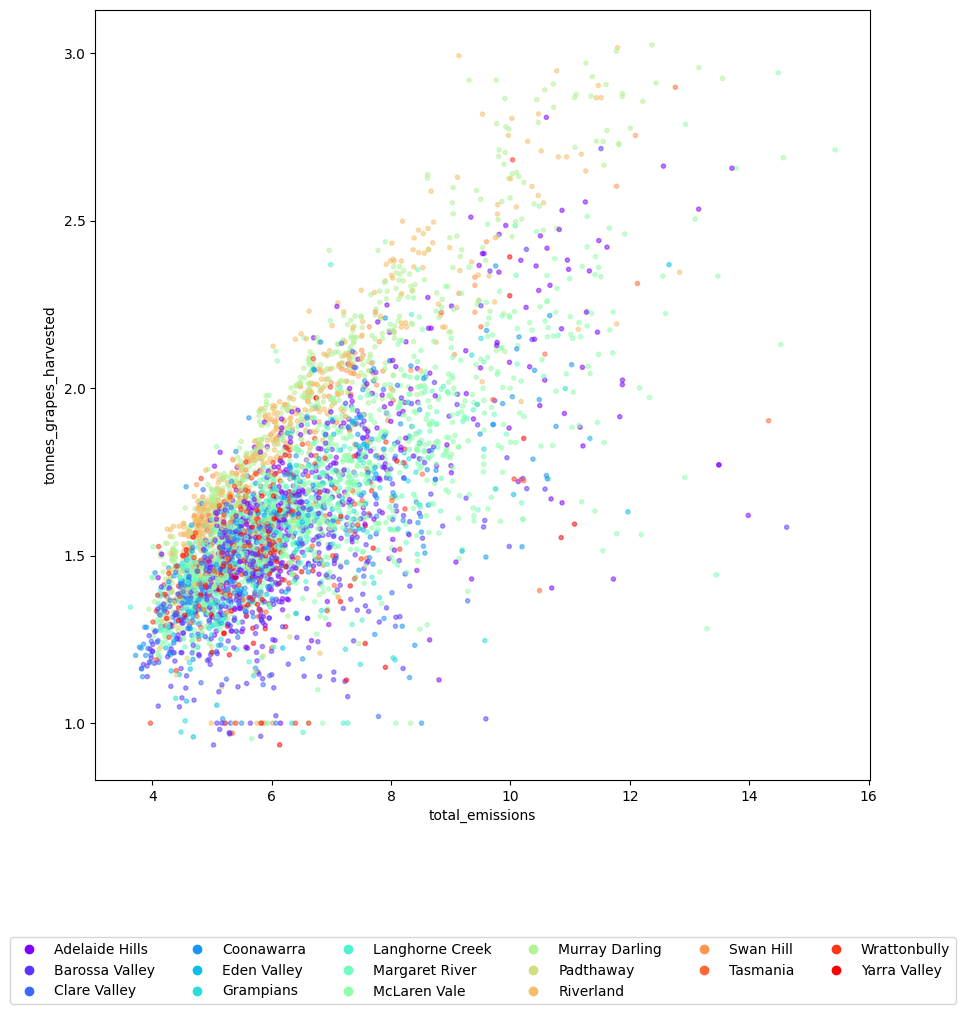

In [156]:
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    df[df["giregion"].isin(region_selection)]["water_and_emmissions"],
    df[df["giregion"].isin(region_selection)]['yield'],
    c=df[df["giregion"].isin(region_selection)]["colors"]
    , label=df["giregion"]
    , marker= "."
    , alpha=0.5
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')


markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in region_color.values()]
plt.legend(markers, region_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

    
plt.show()

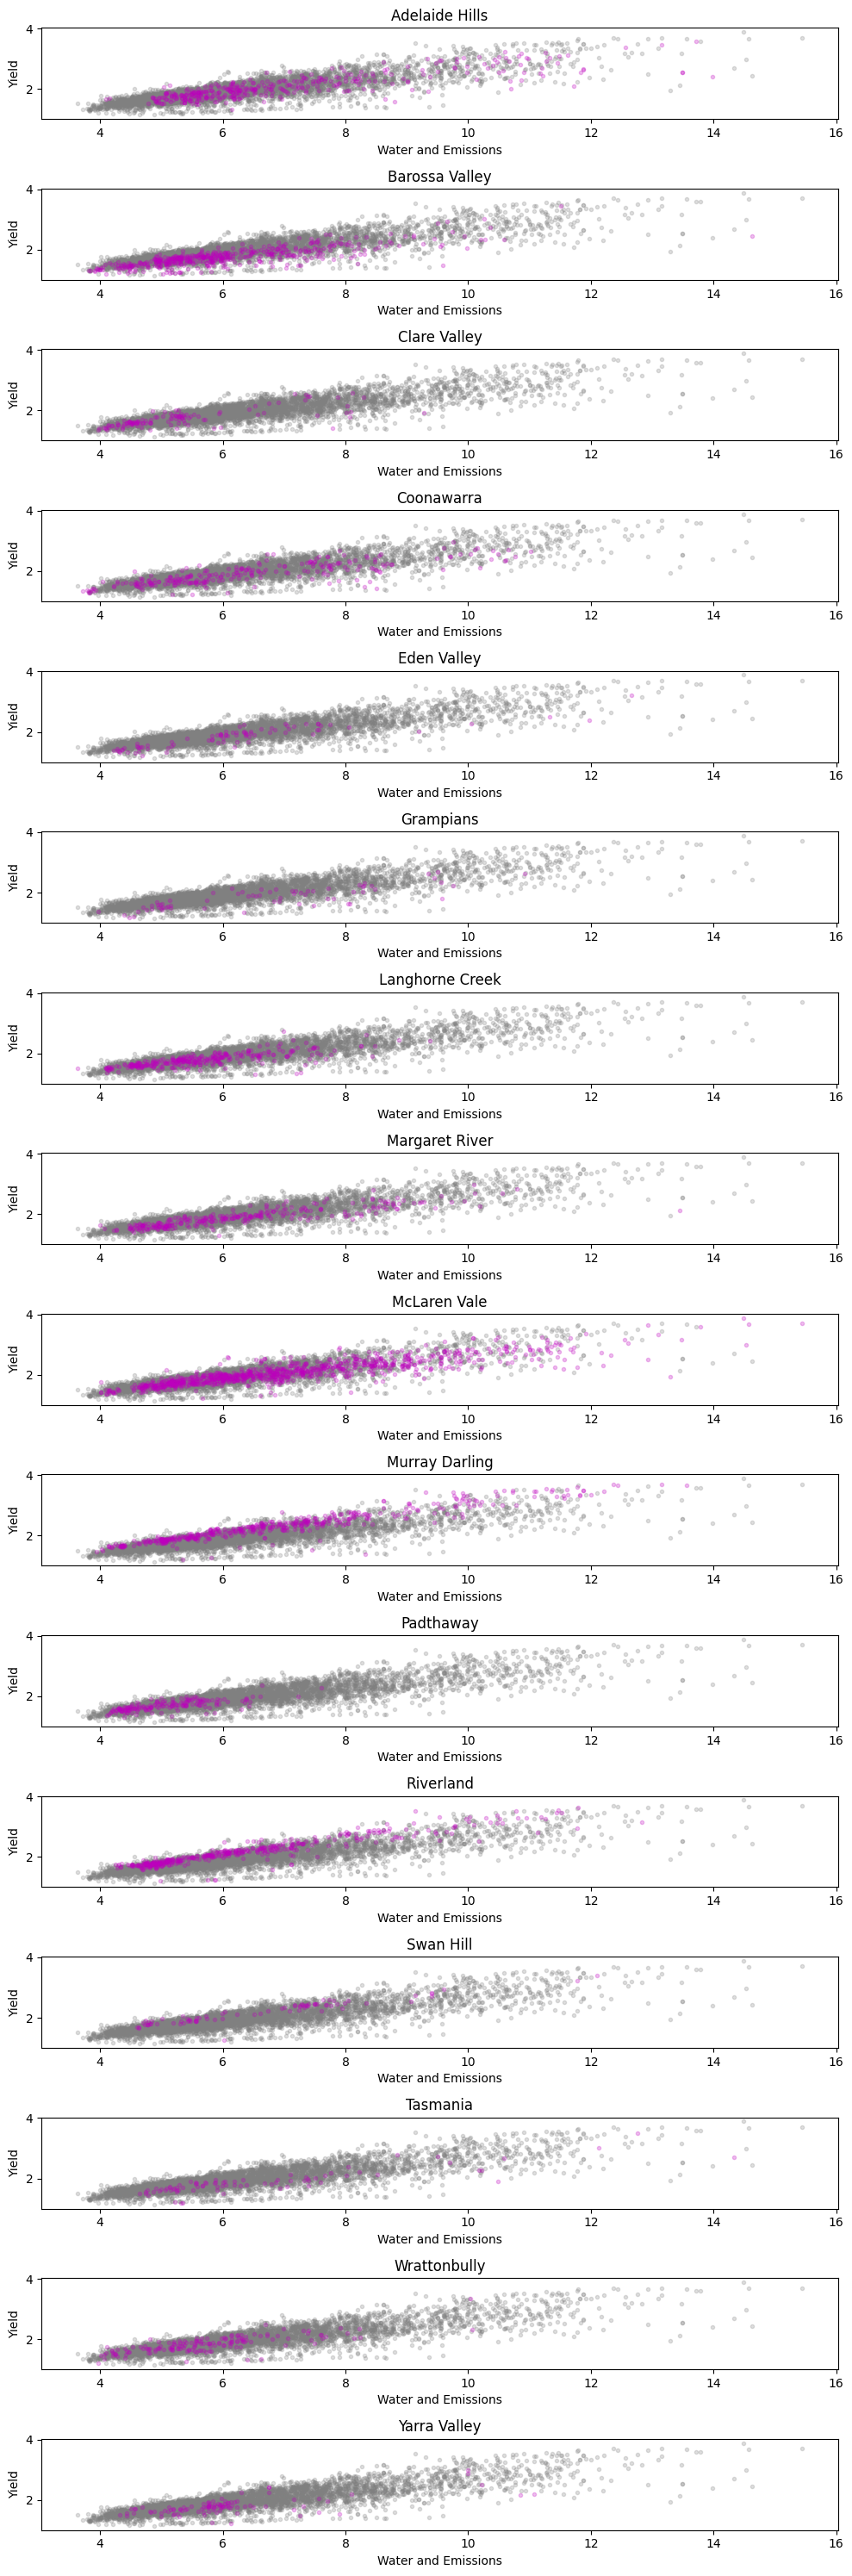

In [157]:
fig, ax = plt.subplots(len(region_selection), 1,  figsize=(10, 30))
i=0

for region in region_selection:
    axscatter = ax[i].scatter(df.loc[df["giregion"]!=region, "water_and_emmissions"]
        , (1+df.loc[df["giregion"]!=region, 'tonnes_grapes_harvested'].apply(np.log)).div((1+df.loc[df["giregion"]!=region, "area_harvested"]).apply(np.log))
        , color="gray"
        , alpha= 0.25
        , label="Other"
        , marker= "."
    )
    scatter = ax[i].scatter(
        df.loc[df["giregion"]==region, "water_and_emmissions"]
        , (1+df.loc[df["giregion"]==region, 'tonnes_grapes_harvested'].apply(np.log)).div((1+df.loc[df["giregion"]==region, "area_harvested"]).apply(np.log))
        , color="m"
        , alpha=0.25
        , label=region
        , marker= "."
    )
    ax[i].set_title(region)
    ax[i].set_xlabel("Water and Emissions")
    ax[i].set_ylabel('Yield')
    
    i += 1

#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in region_color.values()]
#plt.legend(markers, region_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)
fig.tight_layout()
plt.show()

### Finances

In [158]:
df.groupby("giregion")["average_per_tonne"].describe()

count         mean          std      min      25%  \
giregion                                                                      
0                           2.0  1325.000000   388.908730  1050.00  1187.50   
Adelaide Hills             56.0  1888.767857   375.495599  1025.00  1736.50   
Adelaide Plains             5.0  1227.000000   191.428838   935.00  1200.00   
Alpine Valleys              2.0  1125.000000   247.487373   950.00  1037.50   
Barossa Valley             90.0  2763.077778  1228.271163   757.00  2047.00   
Barossa Zone                3.0  2043.333333   487.476495  1530.00  1815.00   
Beechworth                  1.0  2600.000000          NaN  2600.00  2600.00   
Bendigo                    12.0  1478.500000   425.929678   750.00  1350.00   
Big Rivers Zone Other       0.0          NaN          NaN      NaN      NaN   
Blackwood Valley            2.0  1125.000000   318.198052   900.00  1012.50   
Canberra District           2.0  1915.000000   162.634560  1800.00  1857.50   
Clare Valley               20.0  1983.600000   723.763512  1129.00  1469.25   
Coonawarra                 36.0  2128.983333   831.494168  1100.00  1651.75   
Cowra                       0.0          NaN          NaN      NaN      NaN   
Currency Creek              4.0  1554.500000   472.737771  1018.00  1229.50   
Eden Valley                25.0  2097.880000   445.609725  1214.00  1800.00   
Geelong                     0.0          NaN          NaN      NaN      NaN   
Geographe                   0.0          NaN          NaN      NaN      NaN   
Glenrowan                   0.0          NaN          NaN      NaN      NaN   
Goulburn Valley             1.0  1113.000000          NaN  1113.00  1113.00   
Grampians                   5.0  1830.000000   449.444101  1300.00  1450.00   
Great Southern              3.0  2067.166667  1033.251704  1350.00  1475.00   
Gundagai                    1.0   850.000000          NaN   850.00   850.00   
Heathcote                   2.0  1100.000000    70.710678  1050.00  1075.00   
Henty                       0.0          NaN          NaN      NaN      NaN   
Hunter Valley               2.0  1862.500000   265.165043  1675.00  1768.75   
Kangaroo Island             1.0  1300.000000          NaN  1300.00  1300.00   
King Valley                 8.0  1018.755000   113.667347   880.00   937.50   
Langhorne Creek            44.0  1066.195909   373.974365   525.00   830.25   
Macedon Ranges              1.0  3494.000000          NaN  3494.00  3494.00   
Margaret River             44.0  1791.195000   562.190073  1100.00  1393.75   
McLaren Vale              208.0  2362.294615  1781.476660     1.00  1800.00   
Mornington Peninsula        3.0  2833.333333   404.145188  2600.00  2600.00   
Mount Benson                1.0  1600.000000          NaN  1600.00  1600.00   
Mount Gambier               1.0  1600.000000          NaN  1600.00  1600.00   
Mudgee                      6.0  1850.000000   126.491106  1700.00  1762.50   
Murray Darling             55.0   495.602909   177.017989   264.34   399.00   
Orange                     18.0  1637.666667   620.962062   260.00  1269.75   
Other                       3.0  1186.666667  1137.555859   510.00   530.00   
Padthaway                  20.0  1581.235000   712.711361   830.00  1093.75   
Pemberton                   4.0  1486.750000   248.506707  1200.00  1350.00   
Riverina                    0.0          NaN          NaN      NaN      NaN   
Riverland                  81.0   520.746049   192.480467     1.00   430.00   
Robe                        1.0  1200.000000          NaN  1200.00  1200.00   
Rutherglen                  9.0  1315.333333   568.540236   700.00  1015.00   
Southern Fleurieu           4.0  1088.000000   130.802650   952.00   988.00   
Southern Flinders Ranges    1.0   838.000000          NaN   838.00   838.00   
Strathbogie Ranges          1.0  1500.000000          NaN  1500.00  1500.00   
Sunbury                     0.0          NaN          NaN      NaN      NaN 

In [159]:
df.columns

Index(['member_id', 'data_year_id', 'vineyard_area', 'area_harvested',
       'tonnes_grapes_harvested', 'water_used', 'total_tractor_passes',
       'total_vineyard_fuel', 'total_vineyard_electricity',
       'total_irrigation_area', 'synthetic_nitrogen_applied',
       'organic_nitrogen_applied', 'synthetic_fertiliser_applied',
       'organic_fertiliser_applied', 'area_not_harvested',
       'total_irrigation_electricity', 'total_irrigation_fuel', 'giregion',
       'fertilizer_s1', 'fertilizer_s2', 'fertilizer_s3', 'fertilizer_s4',
       'fertilizer_s5', 'fertilizer_o1', 'fertilizer_o2', 'fertilizer_o3',
       'fertilizer_o4', 'fertilizer_o5', 'vineyard_area_white_grapes',
       'vineyard_area_red_grapes', 'river_water', 'groundwater',
       'surface_water_dam', 'recycled_water_from_other_source', 'mains_water',
       'other_water', 'water_applied_for_frost_control', 'bare_soil',
       'annual_cover_crop', 'permanent_cover_crop_native',
       'permanent_cover_crop_non_native

In [160]:
rpy2.ipython.html.init_printing()
r = robjects.r
#feature_list.append("average_per_tonne")

from data import mean_sale_price

avg_prices = df[
    df["average_per_tonne"].isnull()].apply(
    lambda x: mean_sale_price(x["giregion"],
                              x["data_year_id"]),
    axis=1)
df["average_per_tonne"] = df["average_per_tonne"].replace({0: np.nan})
df["average_per_tonne"] = df["average_per_tonne"].combine_first(avg_prices)

dfr = df.loc[df[df["average_per_tonne"]!=0].index, feature_list].copy()
dfr["average_per_tonne"] = df.loc[df[df["average_per_tonne"]!=0].index, "average_per_tonne"]

dfr.to_csv("data.csv")

r.source("linear_model.r")

model = r.linear_model("data.csv", "(log(df$average_per_tonne*df$tonnes_grapes_harvested+1))/log(df$area_harvested+1)"
    "~ log(df$total_emissions+1)/log(df$area_harvested+1) "
    "+ log(df$water_used+1)/log(df$area_harvested+1) "
)


***************
*    ANOVA    *

Analysis of Deviance Table

Model: gaussian, link: identity

Response: (log(df$average_per_tonne * df$tonnes_grapes_harvested + 1))/log(df$area_harvested + 1)

Terms added sequentially (first to last)


                                                       Df Deviance Resid. Df
NULL                                                                    2794
log(df$total_emissions + 1)                             1  2425.01      2793
log(df$water_used + 1)                                  1   152.04      2792
log(df$total_emissions + 1):log(df$area_harvested + 1)  1   259.20      2791
log(df$area_harvested + 1):log(df$water_used + 1)       1   414.71      2790
                                                       Resid. Dev
NULL                                                       3858.5
log(df$total_emissions + 1)                                1433.5
log(df$water_used + 1)                                     1281.5
log(df$total_emissions + 1):log(df$ar

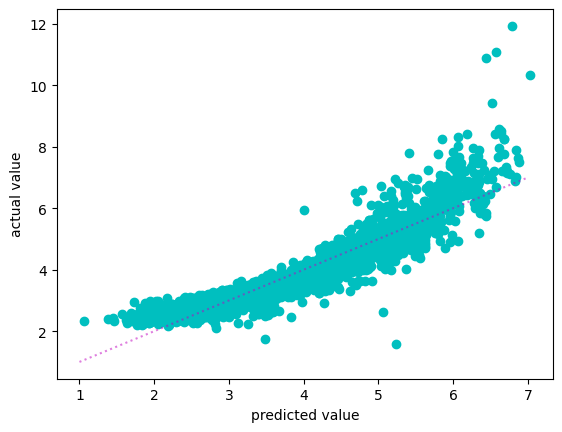

In [161]:
fig, ax = plt.subplots()

plt.plot([1,7], [1,7], color='m', linestyle='dotted', alpha=0.5)
plt.scatter(model[2]
    , model[17]
    , color="c")

plt.xlabel("predicted value")
plt.ylabel("actual value")

plt.show()    

(array([   9.,   11.,   27.,   32.,   49.,   92.,  158.,  431.,  811.,
        1250., 1183.,  578.,  253.,  128.,   74.,   38.,   25.,   22.,
          16.,    2.]),
 array([-1.00992683, -0.90651062, -0.8030944 , -0.69967819, -0.59626198,
        -0.49284576, -0.38942955, -0.28601333, -0.18259712, -0.0791809 ,
         0.02423531,  0.12765153,  0.23106774,  0.33448395,  0.43790017,
         0.54131638,  0.6447326 ,  0.74814881,  0.85156503,  0.95498124,
         1.05839745]),
 <BarContainer object of 20 artists>)

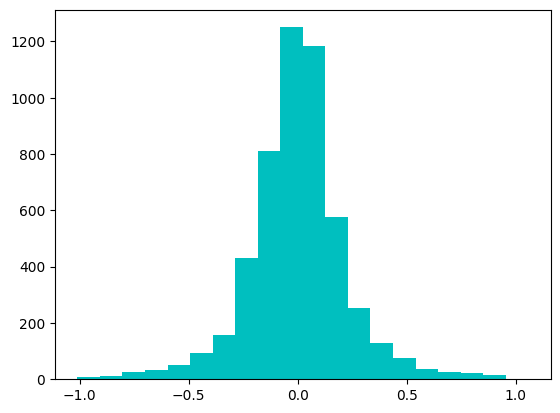

In [162]:
plt.hist(residuals, bins=20, color="c")

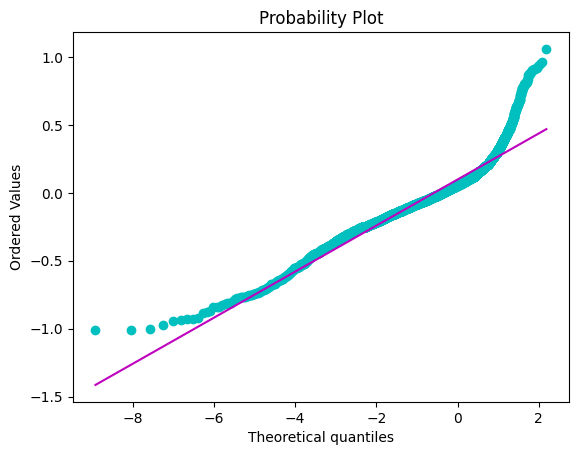

In [163]:
from scipy import stats


from scipy import stats



fig, ax = plt.subplots()

stats.probplot(
    residuals
    , dist=stats.loggamma
    , sparams=(1)
    , plot=ax
)

ax.get_lines()[0].set_color("c")
ax.get_lines()[1].set_color("m")

plt.show()    

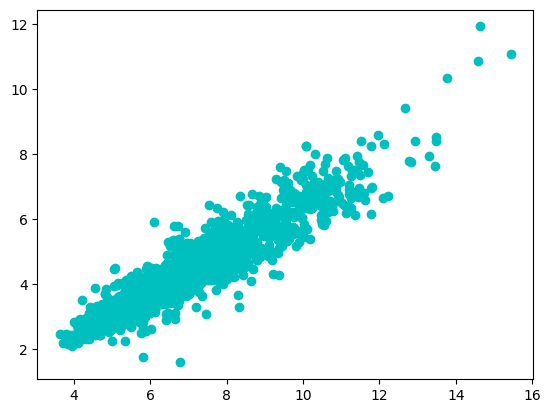

In [164]:
df["yield_avg"] = (1+(df['average_per_tonne']*df['tonnes_grapes_harvested'])).apply(np.log).div((1+df["area_harvested"]).apply(np.log))

plt.scatter(df["water_and_emmissions"], df["yield_avg"], color="c")

plt.show()

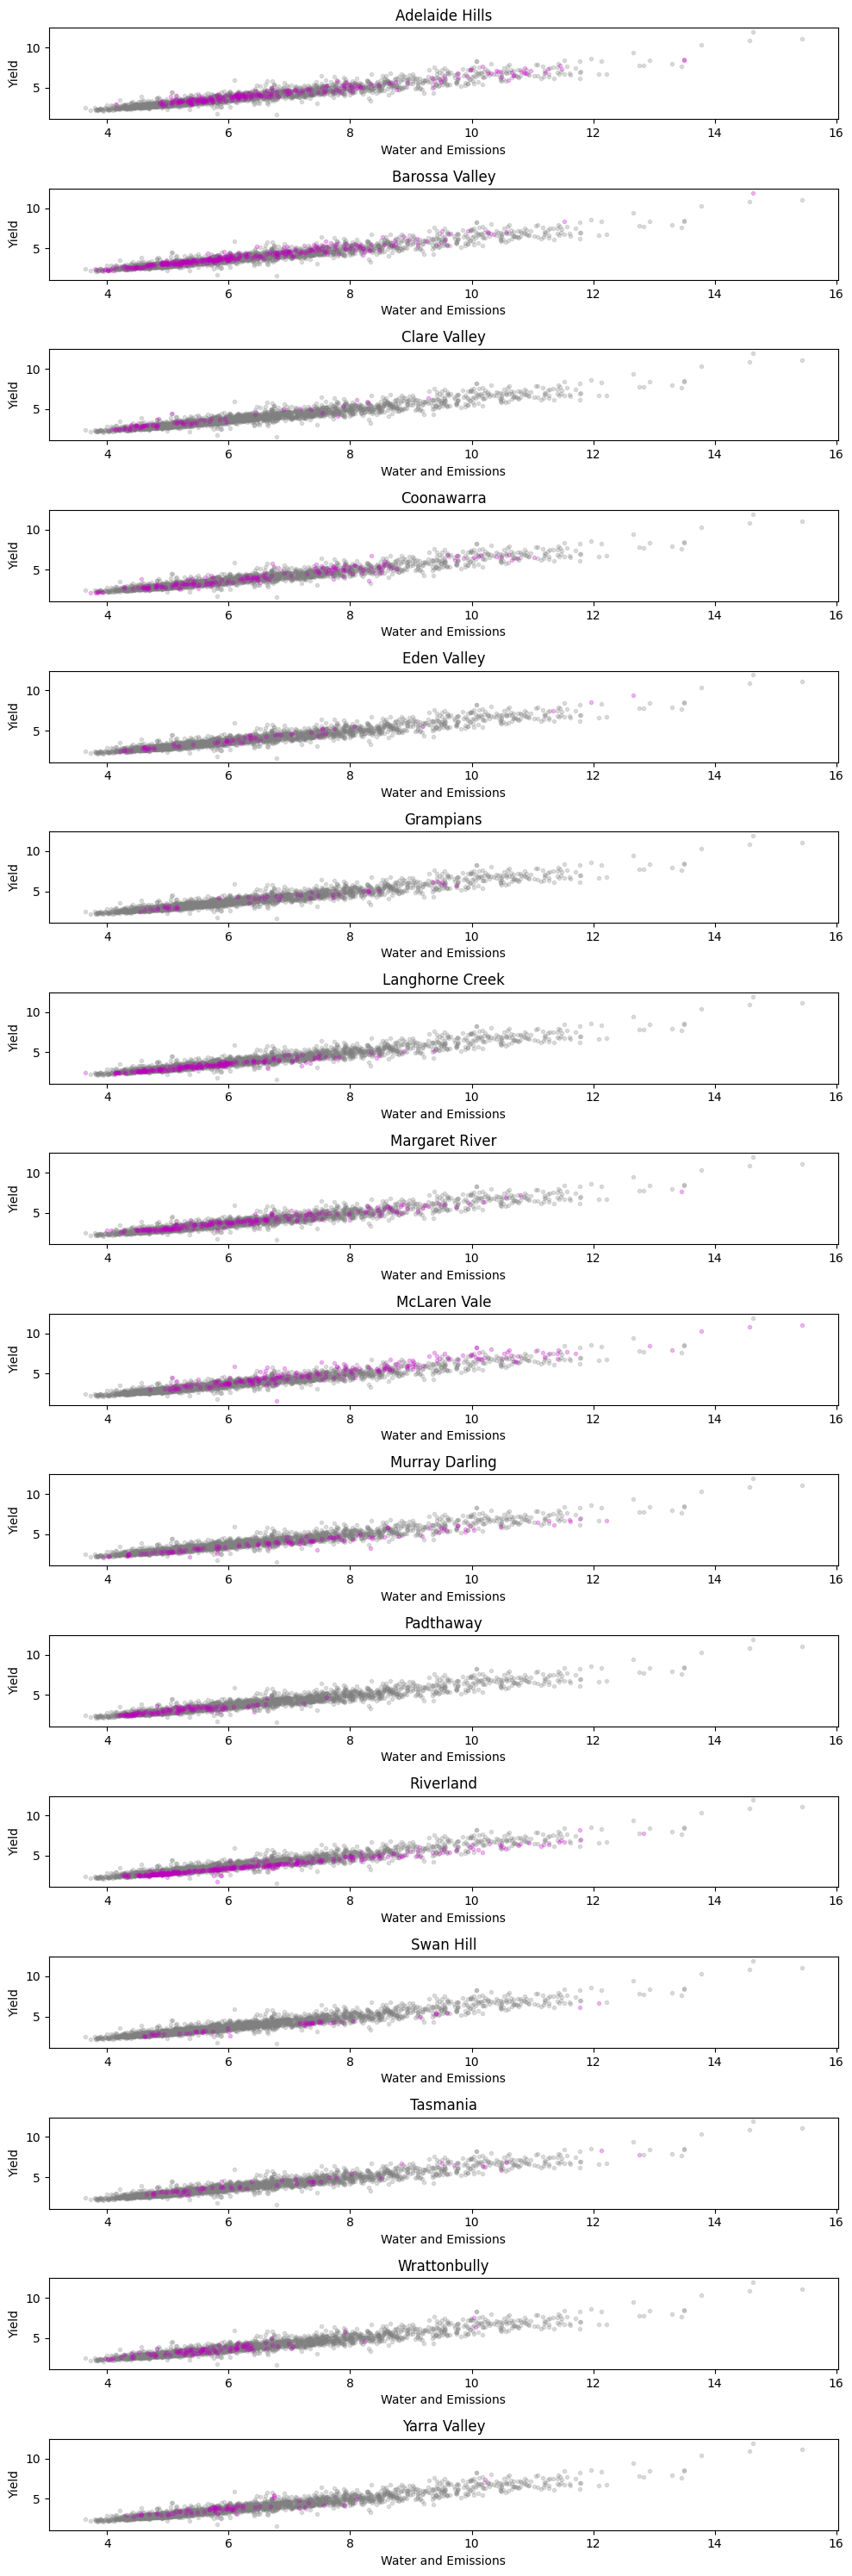

In [165]:
fig, ax = plt.subplots(len(region_selection), 1,  figsize=(10, 30))
i=0

for region in region_selection:
    axscatter = ax[i].scatter(df.loc[df["giregion"]!=region, "water_and_emmissions"]
        , df.loc[df["giregion"]!=region, 'yield_avg']
        , color="gray"
        , alpha= 0.25
        , label="Other"
        , marker= "."
    )
    scatter = ax[i].scatter(
        df.loc[df["giregion"]==region, "water_and_emmissions"]
        , df.loc[df["giregion"]==region, 'yield_avg']
        , color="m"
        , alpha=0.25
        , label=region
        , marker= "."
    )
    ax[i].set_title(region)
    ax[i].set_xlabel("Water and Emissions")
    ax[i].set_ylabel('Yield')
    
    i += 1

#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in region_color.values()]
#plt.legend(markers, region_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)
fig.tight_layout()
plt.show()

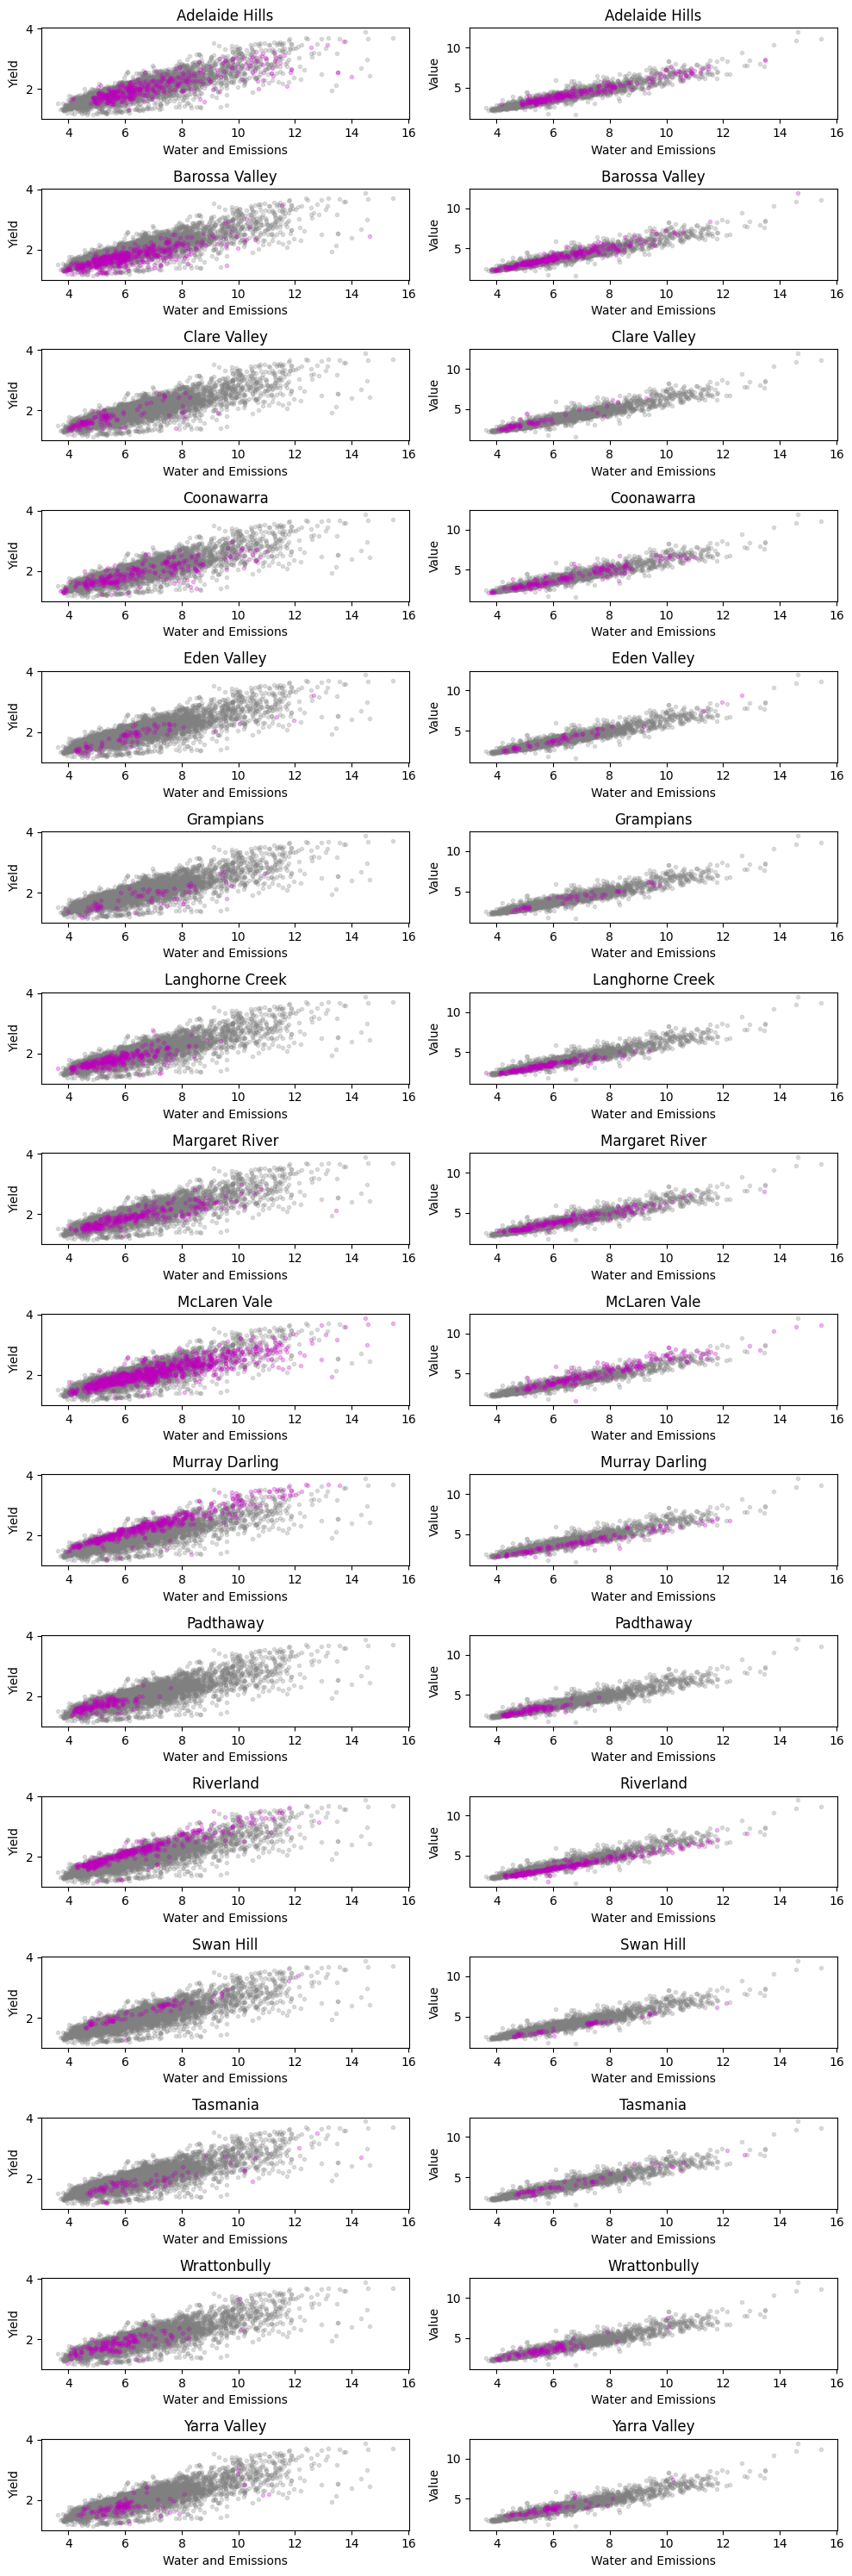

In [166]:
fig, ax = plt.subplots(len(region_selection), 2,  figsize=(10, 30))
i=0

for region in region_selection:
    axscatter = ax[i][0].scatter(df.loc[df["giregion"]!=region, "water_and_emmissions"]
        , (1+df.loc[df["giregion"]!=region, 'tonnes_grapes_harvested'].apply(np.log)).div((1+df.loc[df["giregion"]!=region, "area_harvested"]).apply(np.log))
        , color="gray"
        , alpha= 0.25
        , label="Other"
        , marker= "."
    )
    scatter = ax[i][0].scatter(
        df.loc[df["giregion"]==region, "water_and_emmissions"]
        , (1+df.loc[df["giregion"]==region, 'tonnes_grapes_harvested'].apply(np.log)).div((1+df.loc[df["giregion"]==region, "area_harvested"]).apply(np.log))
        , color="m"
        , alpha=0.25
        , label=region
        , marker= "."
    )
    ax[i][0].set_title(region)
    ax[i][0].set_xlabel("Water and Emissions")
    ax[i][0].set_ylabel('Yield')
    ##
    axscatter = ax[i][1].scatter(df.loc[df["giregion"]!=region, "water_and_emmissions"]
        , df.loc[df["giregion"]!=region, 'yield_avg']
        , color="gray"
        , alpha= 0.25
        , label="Other"
        , marker= "."
    )
    scatter = ax[i][1].scatter(
        df.loc[df["giregion"]==region, "water_and_emmissions"]
        , df.loc[df["giregion"]==region, 'yield_avg']
        , color="m"
        , alpha=0.25
        , label=region
        , marker= "."
    )
    ax[i][1].set_title(region)
    ax[i][1].set_xlabel("Water and Emissions")
    ax[i][1].set_ylabel('Value')
    i += 1

#markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in region_color.values()]
#plt.legend(markers, region_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)
fig.tight_layout()
plt.show()

# CARTS

In [167]:
feature_list

['area_harvested',
 'tonnes_grapes_harvested',
 'water_used',
 'total_tractor_passes',
 'synthetic_nitrogen_applied',
 'organic_nitrogen_applied',
 'synthetic_fertiliser_applied',
 'organic_fertiliser_applied',
 'slashing_number_of_times_passes_per_year',
 'fungicide_spraying_number_of_times_passes_per_year',
 'herbicide_spraying_number_of_times_passes_per_year',
 'insecticide_spraying_number_of_times_passes_per_year',
 'nitrogen_applied',
 'fertiliser_applied',
 'total_emissions']

In [168]:
for col in df.select_dtypes(include=['category']):
    if len(df[col].unique()) == 2:
        df[col] = df[col].apply(lambda x: (np.where(x==1, "True", "False")))

df["yield/ha"] = df["tonnes_grapes_harvested"].div(df["area_harvested"])
df["yield*avg/ha"] = df["tonnes_grapes_harvested"]*df["average_per_tonne"]
df["yield*avg/ha"] = df["yield*avg/ha"].div(df["area_harvested"])

class_features = feature_list
class_features.append("giregion")
class_features.append("yield/ha")
class_features.append("yield*avg/ha")

indices = df[df["giregion"].isin(region_selection)].index 
df.loc[indices, class_features].to_csv("2021.csv")

rpy2.ipython.html.init_printing()

r = robjects.r
r.source('dtree.r')
r.rtree("2021.csv", "giregion"
    "~ tonnes_grapes_harvested"
    "+ total_emissions"
    "+ area_harvested"
    "+ water_used"
    "+ total_tractor_passes"
    "+ synthetic_nitrogen_applied"
    "+ organic_nitrogen_applied"
    "+ synthetic_fertiliser_applied"
    "+ organic_fertiliser_applied"
    "+ slashing_number_of_times_passes_per_year"
    "+ fungicide_spraying_number_of_times_passes_per_year"
    "+ herbicide_spraying_number_of_times_passes_per_year"
    "+ insecticide_spraying_number_of_times_passes_per_year"
    "+ nitrogen_applied"
    "+ fertiliser_applied"
    , "giregion"
)


Classification tree:
rpart(formula = formula, data = df)

Variables actually used in tree construction:
[1] area_harvested                                    
[2] fungicide_spraying_number_of_times_passes_per_year
[3] water_used                                        

Root node error: 3520/4497 = 0.78274

n= 4497 

        CP nsplit rel error  xerror      xstd
1 0.060795      0   1.00000 1.00000 0.0078562
2 0.022443      1   0.93920 0.93807 0.0084153
3 0.014205      3   0.89432 0.89261 0.0087412
4 0.010000      4   0.88011 0.87756 0.0088350
[1] "Variable Importance:"
                                        water_used 
                                         219.00820 
                                    area_harvested 
                                         175.22050 
                           tonnes_grapes_harvested 
                                         158.11346 
                                   total_emissions 
                                         114.02881 
fungicid

<rpy2.robjects.vectors.StrVector object at 0x7f6af307bb80> [RTYPES.STRSXP]
R classes: ('character',)
['Incorrect: % 68.89']

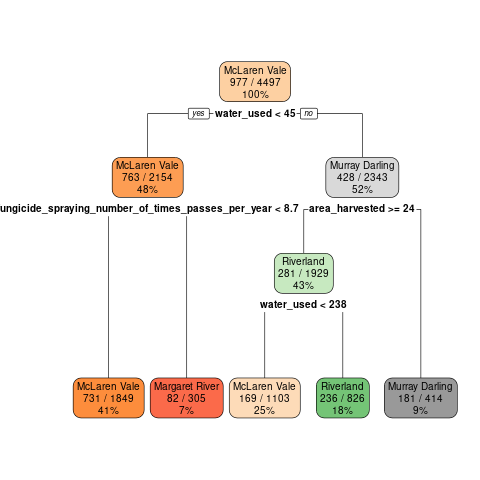

In [169]:
from IPython import display
display.Image(filename=".tree.png")

### Regional Climates

In [170]:
df["rain"] = df["giregion"].apply(rain)
df["temp"] = df["giregion"].apply(temp)
df.loc[df["rain"]=="Unknown Climate", "rain"] = np.nan
df.loc[df["temp"]=="Unknown Climate", "temp"] = np.nan
df["climate"] = df["temp"] + " " + df["rain"]
df.loc[df["climate"]=="Unknown Climate Unknown Climate", "climate"] = np.nan

In [171]:
df["climate"].unique()

array(['Mild Very Dry', 'Warm Damp', 'Cool Dry', 'Warm Very Dry',
       'Cool Damp', 'Hot Very Dry', nan, 'Mild Dry', 'Hot Damp',
       'Warm Dry', 'Mild Damp', 'Cool Very Dry'], dtype=object)

<AxesSubplot: >

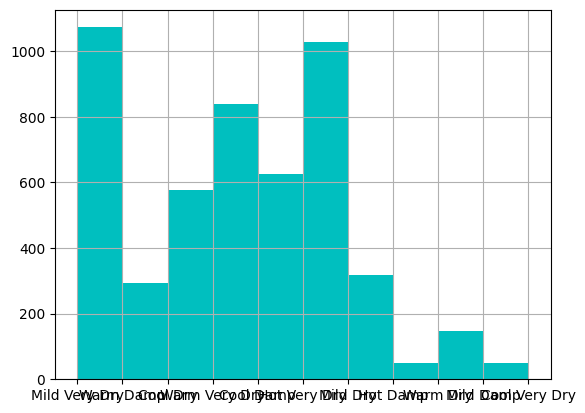

In [172]:
df["climate"].hist(color="c")

<AxesSubplot: >

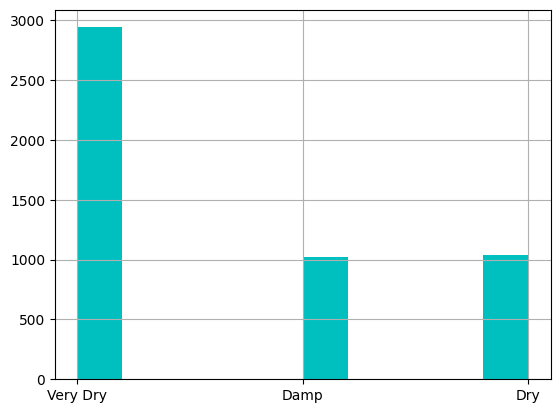

In [173]:
df["rain"].hist(color="c")

<AxesSubplot: >

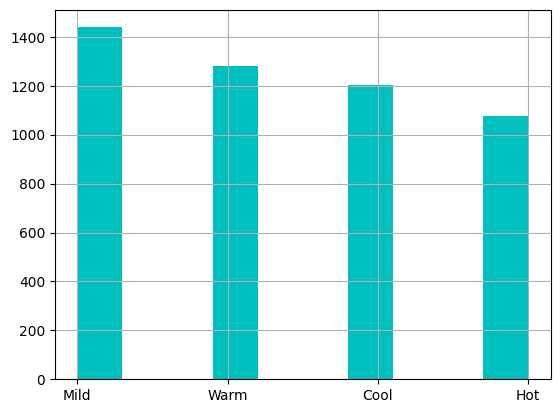

In [174]:
df["temp"].hist(color="c")

In [175]:
df["yield/ha"] = df["tonnes_grapes_harvested"].div(df["area_harvested"])
df["yield*avg/ha"] = df["tonnes_grapes_harvested"]*df["average_per_tonne"]
df["yield*avg/ha"] = df["yield*avg/ha"].div(df["area_harvested"])

class_features = feature_list
class_features.append("giregion")
class_features.append("yield/ha")
class_features.append("yield*avg/ha")
class_features.append("rain")
class_features.append("temp")
class_features.append("climate")

In [176]:
for col in df.select_dtypes(include=['category']):
    if len(df[col].unique()) == 2:
        df[col] = df[col].apply(lambda x: (np.where(x==1, "True", "False")))

df.loc[df["climate"].notnull(), class_features].to_csv("2021.csv")

rpy2.ipython.html.init_printing()

r = robjects.r
r.source('dtree.r')
all_regions = r.rtree("2021.csv", "climate"
    "~ tonnes_grapes_harvested"
    "+ total_emissions"
    "+ area_harvested"
    "+ water_used"
    "+ total_tractor_passes"
    "+ synthetic_nitrogen_applied"
    "+ organic_nitrogen_applied"
    "+ synthetic_fertiliser_applied"
    "+ organic_fertiliser_applied"
    "+ slashing_number_of_times_passes_per_year"
    "+ fungicide_spraying_number_of_times_passes_per_year"
    "+ herbicide_spraying_number_of_times_passes_per_year"
    "+ insecticide_spraying_number_of_times_passes_per_year"
    "+ nitrogen_applied"
    "+ fertiliser_applied"
    , "climate"
)


Classification tree:
rpart(formula = formula, data = df)

Variables actually used in tree construction:
[1] area_harvested                                    
[2] fungicide_spraying_number_of_times_passes_per_year
[3] slashing_number_of_times_passes_per_year          
[4] water_used                                        

Root node error: 3929/5002 = 0.78549

n= 5002 

        CP nsplit rel error  xerror      xstd
1 0.169254      0   1.00000 1.00000 0.0073890
2 0.025706      1   0.83075 0.83304 0.0085608
3 0.024434      3   0.77933 0.80300 0.0086872
4 0.012217      4   0.75490 0.75974 0.0088302
5 0.010000      5   0.74268 0.75006 0.0088561
[1] "Variable Importance:"
                                        water_used 
                                         343.33451 
                                    area_harvested 
                                         308.16756 
                           tonnes_grapes_harvested 
                                         252.45838 
           

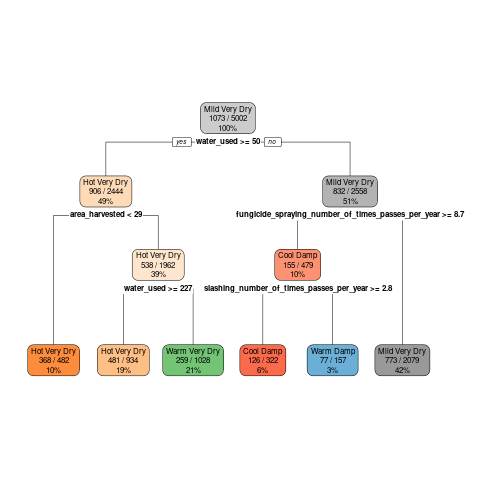

In [177]:
from IPython import display
display.Image(filename=".tree.png")

In [178]:
for col in df.select_dtypes(include=['category']):
    if len(df[col].unique()) == 2:
        df[col] = df[col].apply(lambda x: (np.where(x==1, "True", "False")))

df["yield/ha"] = df["tonnes_grapes_harvested"].div(df["area_harvested"])
df["yield*avg/ha"] = df["tonnes_grapes_harvested"]*df["average_per_tonne"]
df["yield*avg/ha"] = df["yield*avg/ha"].div(df["area_harvested"])

df.loc[df["climate"].notnull(), class_features].to_csv("2021.csv")

rpy2.ipython.html.init_printing()

r = robjects.r
r.source('dtree.r')
r.rtree("2021.csv", "rain"
    "~ tonnes_grapes_harvested"
    "+ total_emissions"
    "+ area_harvested"
    "+ water_used"
    "+ total_tractor_passes"
    "+ synthetic_nitrogen_applied"
    "+ organic_nitrogen_applied"
    "+ synthetic_fertiliser_applied"
    "+ organic_fertiliser_applied"
    "+ slashing_number_of_times_passes_per_year"
    "+ fungicide_spraying_number_of_times_passes_per_year"
    "+ herbicide_spraying_number_of_times_passes_per_year"
    "+ insecticide_spraying_number_of_times_passes_per_year"
    "+ nitrogen_applied"
    "+ fertiliser_applied"
    , "rain"
)


Classification tree:
rpart(formula = formula, data = df)

Variables actually used in tree construction:
[1] fungicide_spraying_number_of_times_passes_per_year
[2] water_used                                        

Root node error: 2060/5002 = 0.41184

n= 5002 

        CP nsplit rel error  xerror     xstd
1 0.060194      0   1.00000 1.00000 0.016897
2 0.016990      1   0.93981 0.93932 0.016721
3 0.010000      2   0.92282 0.92573 0.016675
[1] "Variable Importance:"
fungicide_spraying_number_of_times_passes_per_year 
                                         119.01765 
                              total_tractor_passes 
                                          37.69387 
                                        water_used 
                                          32.28867 
                           tonnes_grapes_harvested 
                                          20.09949 
                                    area_harvested 
                                          14.85615 
         

<rpy2.robjects.vectors.StrVector object at 0x7f6af1e0ec00> [RTYPES.STRSXP]
R classes: ('character',)
['Incorrect: % 38']

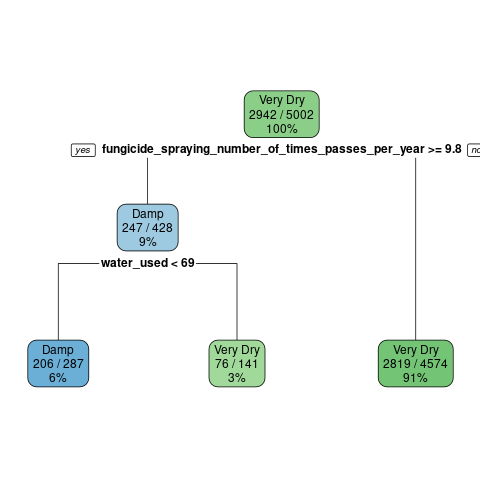

In [179]:
from IPython import display
display.Image(filename=".tree.png")

In [180]:
for col in df.select_dtypes(include=['category']):
    if len(df[col].unique()) == 2:
        df[col] = df[col].apply(lambda x: (np.where(x==1, "True", "False")))

df["yield/ha"] = df["tonnes_grapes_harvested"].div(df["area_harvested"])
df["yield*avg/ha"] = df["tonnes_grapes_harvested"]*df["average_per_tonne"]
df["yield*avg/ha"] = df["yield*avg/ha"].div(df["area_harvested"])
    
df.loc[df["climate"].notnull(), class_features].to_csv("2021.csv")

rpy2.ipython.html.init_printing()

r = robjects.r
r.source('dtree.r')
r.rtree("2021.csv", "temp"
    "~ tonnes_grapes_harvested"
    "+ total_emissions"
    "+ area_harvested"
    "+ water_used"
    "+ total_tractor_passes"
    "+ synthetic_nitrogen_applied"
    "+ organic_nitrogen_applied"
    "+ synthetic_fertiliser_applied"
    "+ organic_fertiliser_applied"
    "+ slashing_number_of_times_passes_per_year"
    "+ fungicide_spraying_number_of_times_passes_per_year"
    "+ herbicide_spraying_number_of_times_passes_per_year"
    "+ insecticide_spraying_number_of_times_passes_per_year"
    "+ nitrogen_applied"
    "+ fertiliser_applied"
    , "temp"
)


Classification tree:
rpart(formula = formula, data = df)

Variables actually used in tree construction:
[1] area_harvested       total_emissions      total_tractor_passes
[4] water_used          

Root node error: 3563/5002 = 0.71232

n= 5002 

        CP nsplit rel error  xerror      xstd
1 0.130508      0   1.00000 1.00000 0.0089857
2 0.043783      1   0.86949 0.87033 0.0096351
3 0.024979      2   0.82571 0.82262 0.0097771
4 0.021330      5   0.75077 0.76986 0.0098783
5 0.017120      6   0.72944 0.74179 0.0099089
6 0.010000      7   0.71232 0.72607 0.0099190
[1] "Variable Importance:"
                                        water_used 
                                        414.447164 
                                    area_harvested 
                                        373.667905 
                           tonnes_grapes_harvested 
                                        278.329345 
                                   total_emissions 
                                        2

<rpy2.robjects.vectors.StrVector object at 0x7f6b2bf90f80> [RTYPES.STRSXP]
R classes: ('character',)
['Incorrect: % 50.74']

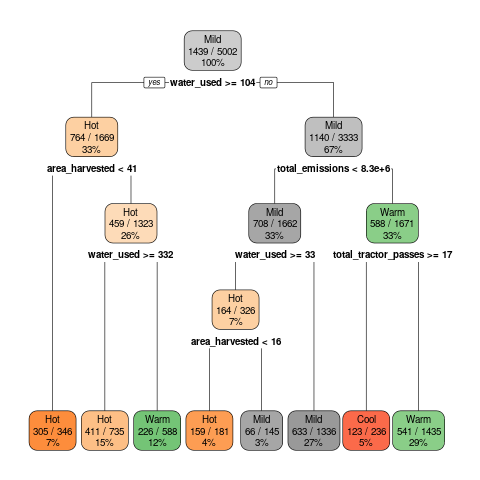

In [181]:
from IPython import display
display.Image(filename=".tree.png")

In [182]:
palette=[
        "#009292",
        "#ff6db6",
        "#490092",
        "#b66dff",
        "#6db6ff",
        "#b6dbff",
        "#920000",
        "#db6d00",
        "#24ff24",
        "#ffff6d",
        "#006ddb",
        "#000000",
        "#004949",
        "#ffb6db",
        "#924900",
    ]

import matplotlib.cm as cm

climate_color = {}
color = iter(palette)

climate_selection = df["climate"].unique()

for i in range(len(climate_selection)):
   climate_color[climate_selection[i]] = i = next(color)

df['clim_colors'] = df.loc[df["climate"].notnull(), "climate"].apply(lambda x: climate_color[x])

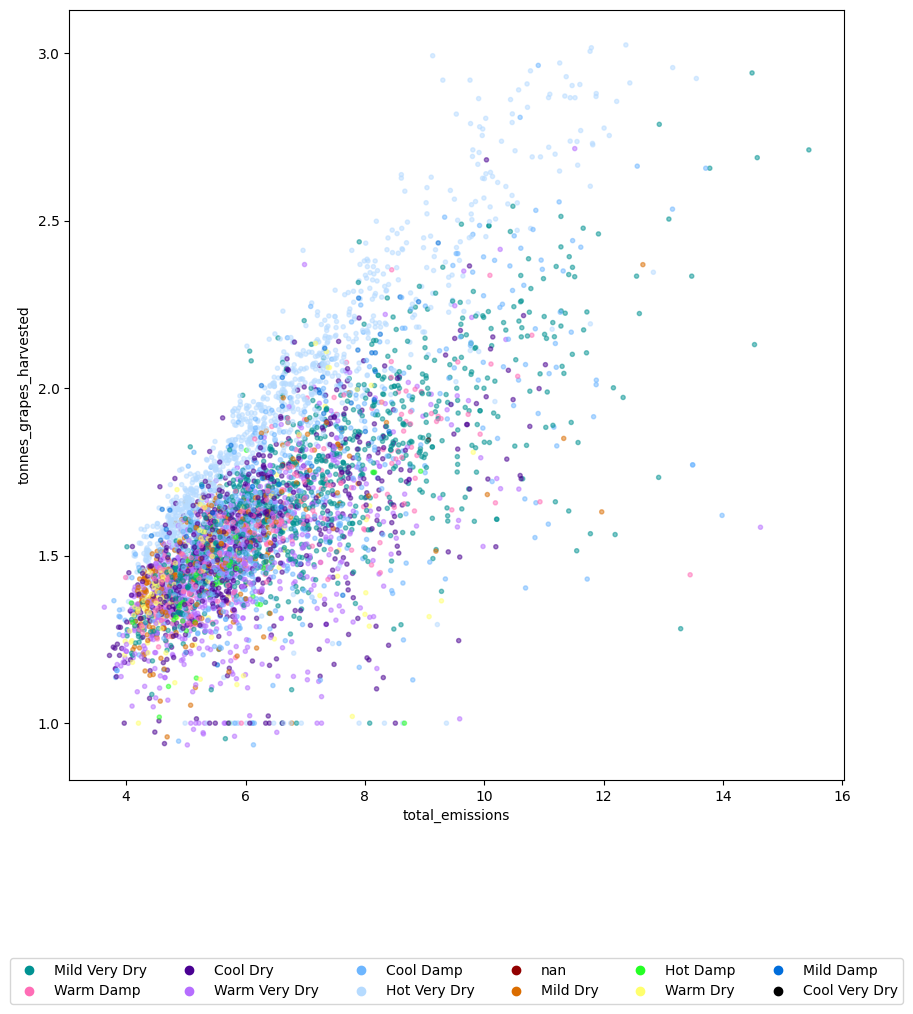

In [183]:
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    df.loc[df["climate"].notnull(),"water_and_emmissions"],
    df.loc[df["climate"].notnull(),'yield'],
    c=df.loc[df["climate"].notnull(),"clim_colors"]
    , label=df.loc[df["climate"].notnull(),"climate"]
    , marker= "."
    , alpha=0.5
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in climate_color.values()]
plt.legend(markers, climate_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

plt.show()

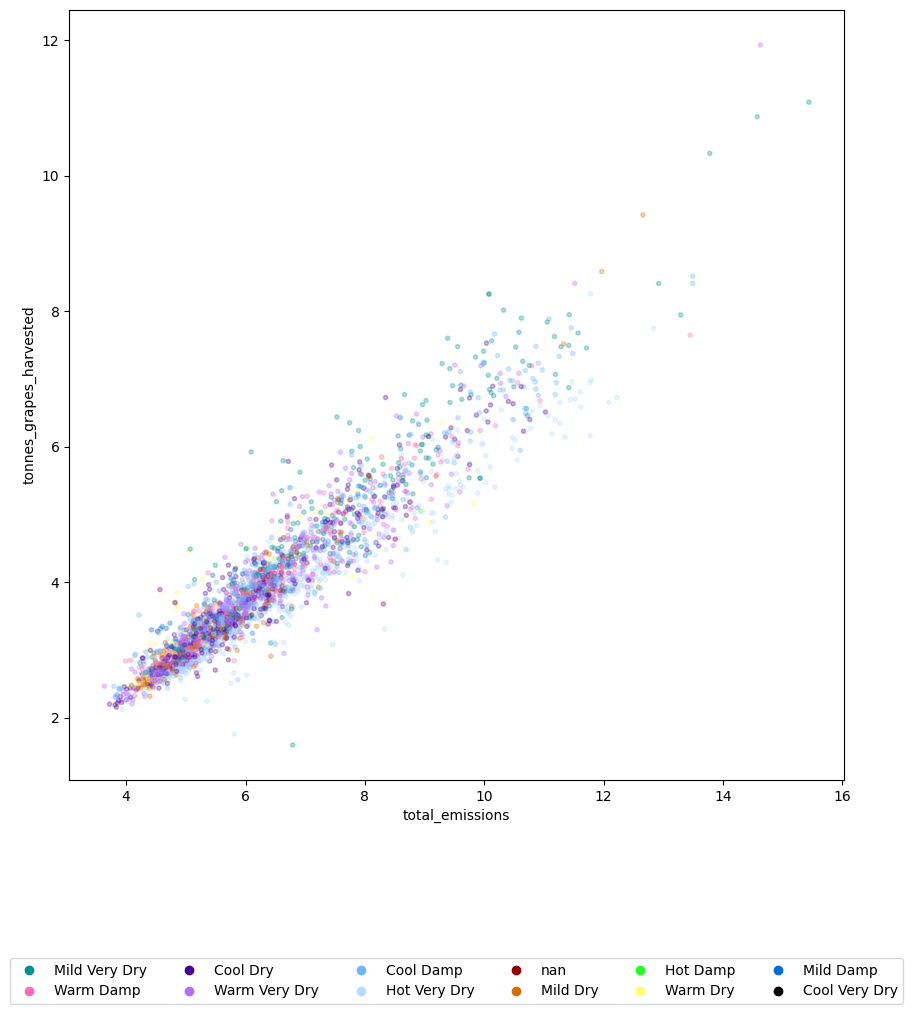

In [184]:
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    df.loc[df["climate"].notnull(),"water_and_emmissions"],
    df.loc[df["climate"].notnull(),'yield_avg'],
    c=df.loc[df["climate"].notnull(),"clim_colors"]
    , label=df.loc[df["climate"].notnull(),"climate"]
    , marker= "."
    , alpha=0.3
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')


markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in climate_color.values()]
plt.legend(markers, climate_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

    
plt.show()

In [185]:
import matplotlib.cm as cm

rain_color = {}
color = iter(palette)

rain_selection = df.loc[df["climate"].notnull(), "rain"].unique()

for i in range(len(rain_selection)):
   rain_color[rain_selection[i]] = i = next(color)

df['rain_colors'] = df.loc[df["climate"].notnull(),"rain"].apply(lambda x: rain_color[x])

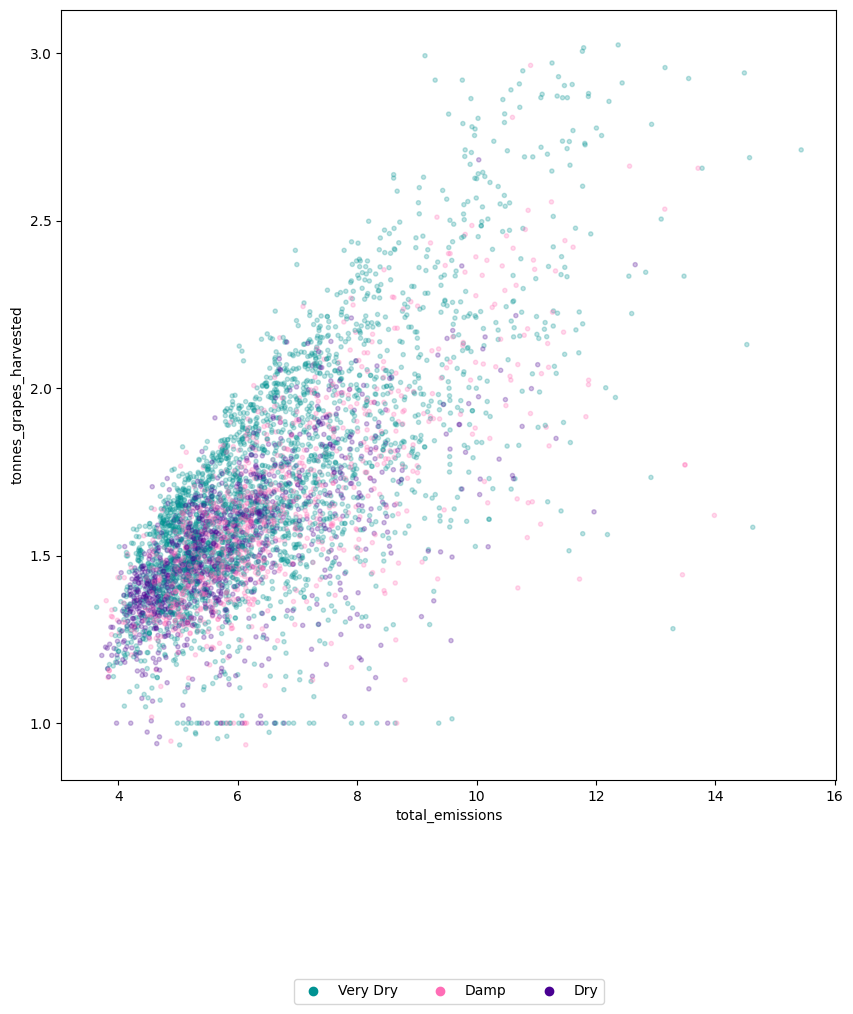

In [186]:
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    df.loc[df["climate"].notnull(), "water_and_emmissions"],
    df.loc[df["climate"].notnull(), 'yield'],
    c=df.loc[df["climate"].notnull(), "rain_colors"]
    , label=df.loc[df["climate"].notnull(), "rain"]
    , marker= "."
    , alpha=0.25
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in rain_color.values()]
plt.legend(markers, rain_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

plt.show()

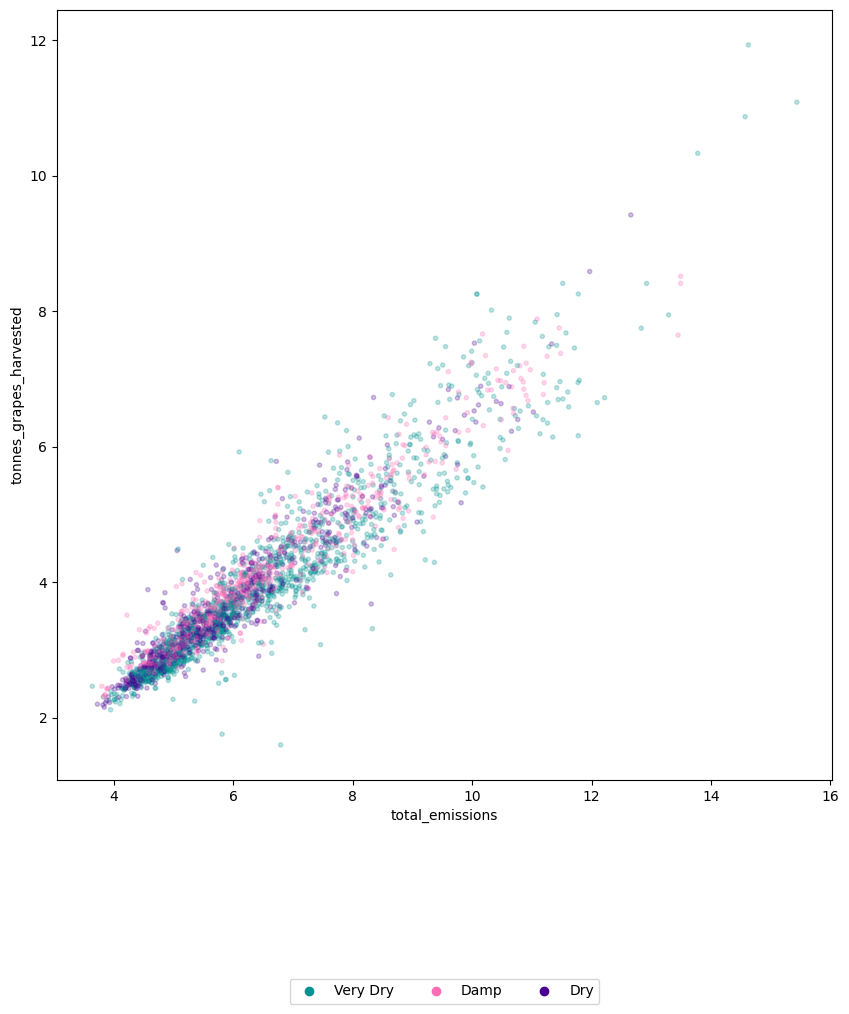

In [187]:
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    df.loc[df["climate"].notnull(), "water_and_emmissions"],
    df.loc[df["climate"].notnull(), 'yield_avg'],
    c=df.loc[df["climate"].notnull(), "rain_colors"]
    , label=df.loc[df["climate"].notnull(), "rain"]
    , marker= "."
    , alpha=0.25
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested * average grape price')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in rain_color.values()]
plt.legend(markers, rain_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

plt.show()

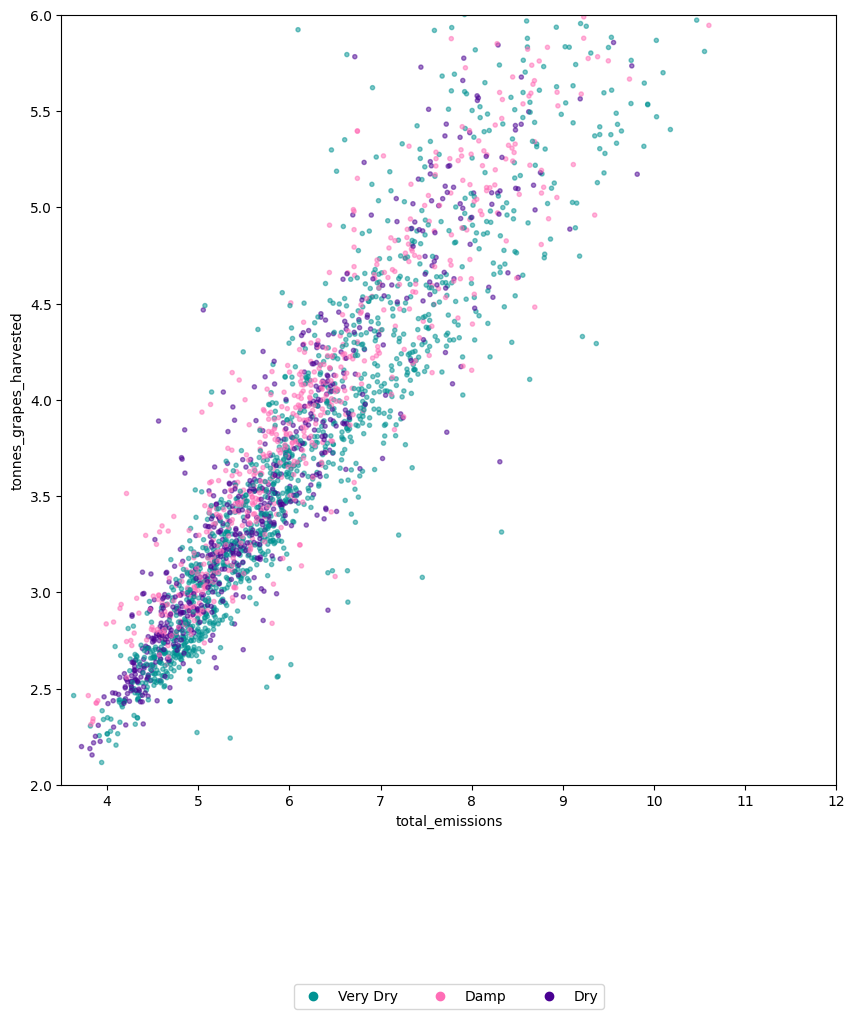

In [188]:
fig, ax = plt.subplots(figsize=(10, 10))
rain_map = {'Very Dry': "brown", 'Damp': "blue", 'Dry': "brown", 'Unknown Climate': None}

scatter = ax.scatter(
    df.loc[df["climate"].notnull(), "water_and_emmissions"],
    df.loc[df["climate"].notnull(), 'yield_avg'],
    c=df.loc[df["climate"].notnull(), "rain_colors"]
    , label=df.loc[df["climate"].notnull(), "rain"]
    , marker= "."
    , alpha=.5
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested * average grape price')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')
ax.set_xlim([3.5,12])
ax.set_ylim([2,6])

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in rain_color.values()]
plt.legend(markers, rain_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

plt.show()

In [189]:
temp_selection = df.groupby("temp").count()[(df.groupby("temp").count()>50)["member_id"]].index.values

import matplotlib.cm as cm

temp_color = {}
color = iter(palette)
temp_selection = df.loc[df["climate"].notnull(), "temp"].unique()

for i in range(len(temp_selection)):
   temp_color[temp_selection[i]] = i = next(color)

df['temp_colors'] = df.loc[df["climate"].notnull(), "temp"].apply(lambda x: temp_color[x])

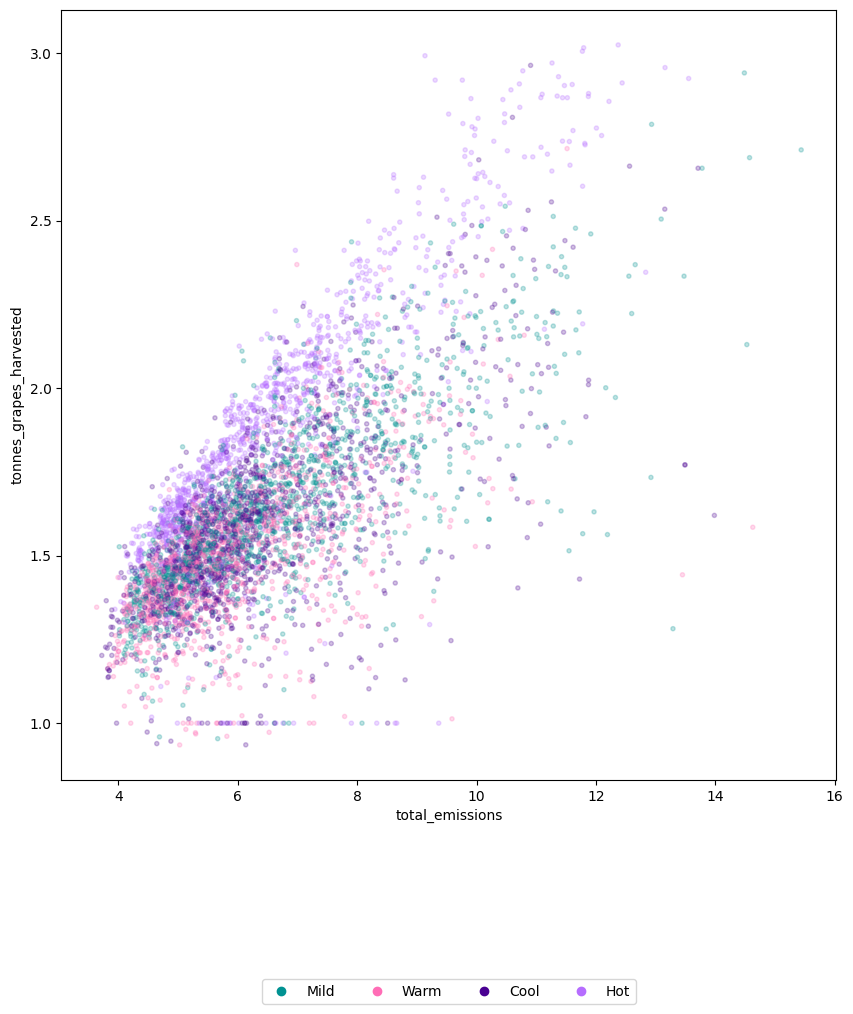

In [190]:
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    df.loc[df["climate"].notnull(), "water_and_emmissions"],
    df.loc[df["climate"].notnull(), 'yield'],
    c=df.loc[df["climate"].notnull(), "temp_colors"]
    , label=df.loc[df["climate"].notnull(), "temp"]
    , marker= "."
    , alpha=0.25
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in temp_color.values()]
plt.legend(markers, temp_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

plt.show()

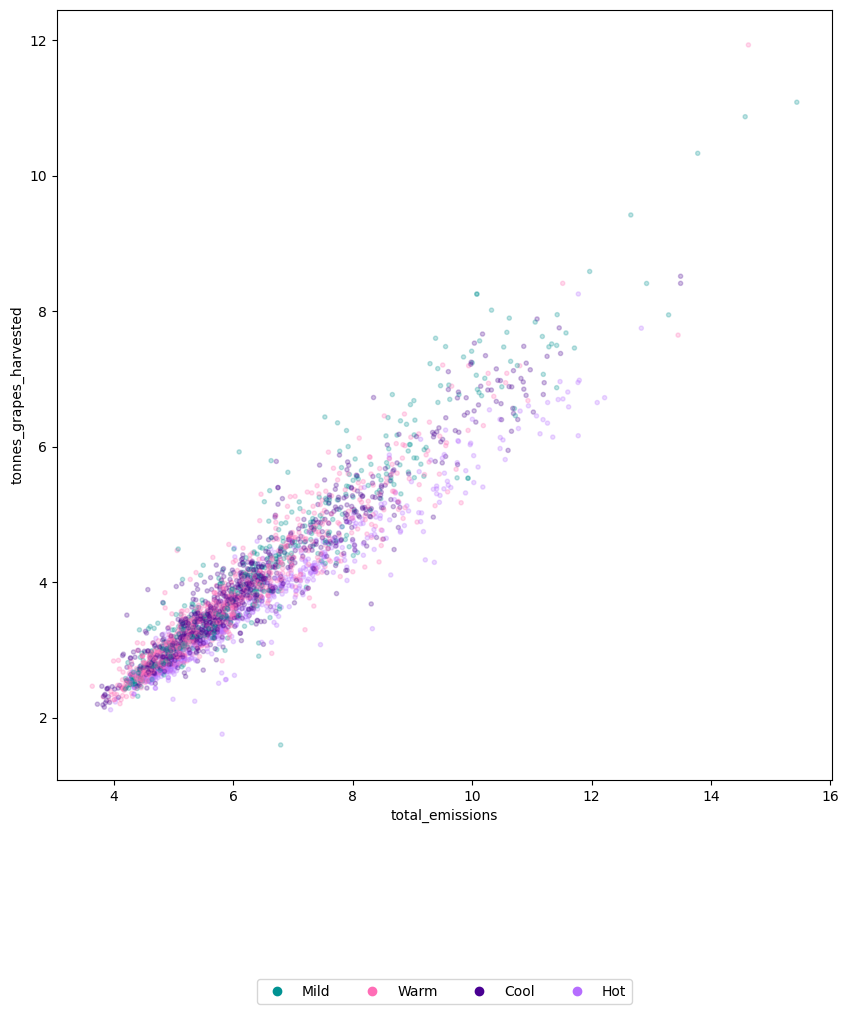

In [191]:
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    df.loc[df["climate"].notnull(), "water_and_emmissions"],
    df.loc[df["climate"].notnull(), 'yield_avg'],
    c=df.loc[df["climate"].notnull(), "temp_colors"]
    , label=df.loc[df["climate"].notnull(), "temp"]
    , marker= "."
    , alpha=0.25
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in temp_color.values()]
plt.legend(markers, temp_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

plt.show()

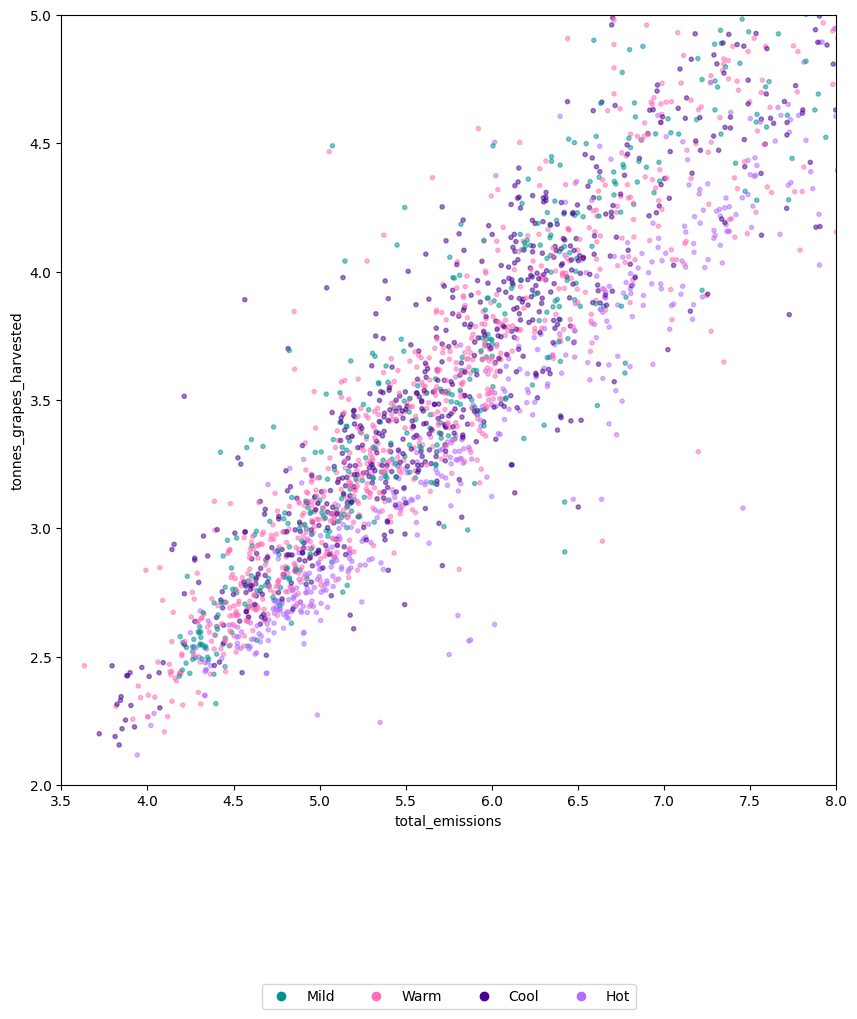

In [192]:
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    df.loc[df["climate"].notnull(), "water_and_emmissions"],
    df.loc[df["climate"].notnull(), 'yield_avg'],
    c=df.loc[df["climate"].notnull(), "temp_colors"]
    , label=df.loc[df["climate"].notnull(), "temp"]
    , marker= "."
    , alpha=0.5
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')

ax.set_xlim([3.5,8])
ax.set_ylim([2,5])

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in temp_color.values()]
plt.legend(markers, temp_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

plt.show()

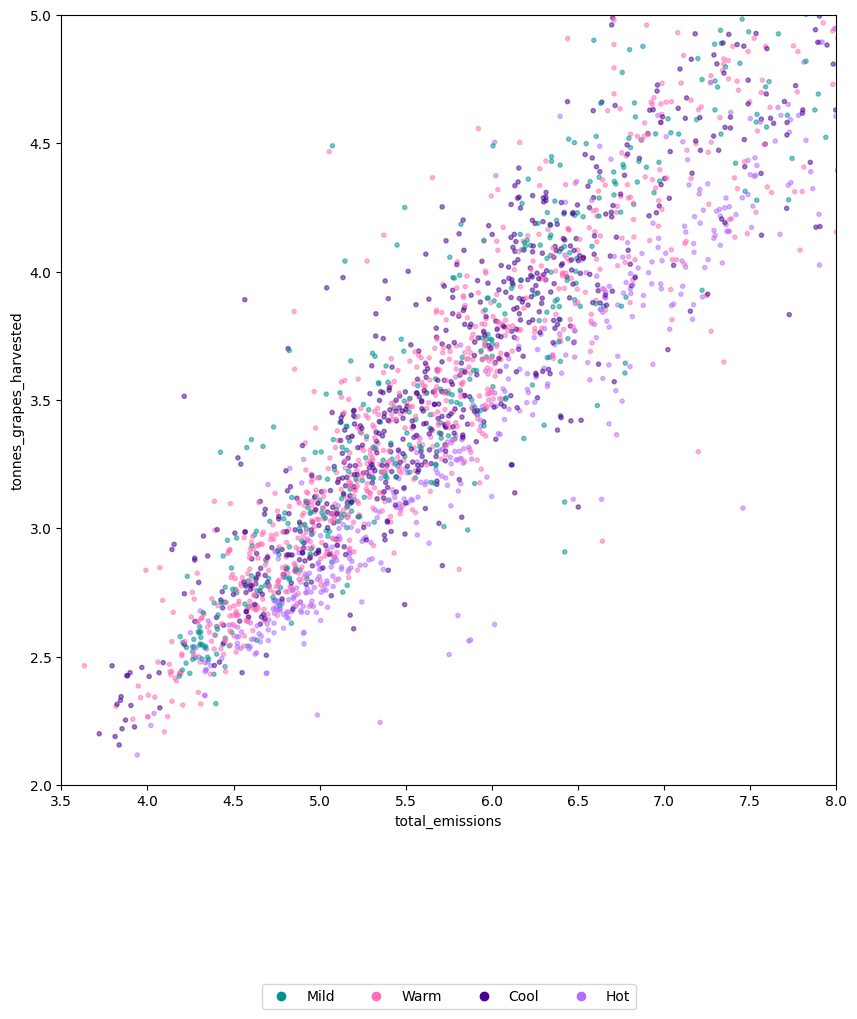

In [193]:
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    df.loc[df["climate"].notnull(), "water_and_emmissions"],
    df.loc[df["climate"].notnull(), 'yield_avg'],
    c=df.loc[df["climate"].notnull(), "temp_colors"]
    , label=df.loc[df["climate"].notnull(), "temp"]
    , marker= "."
    , alpha=0.5
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')

ax.set_xlim([3.5,8])
ax.set_ylim([2,5])

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in temp_color.values()]
plt.legend(markers, temp_selection, loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

plt.show()

In [212]:
df["use_contractors"] = df['slashing_number_of_times_passes_per_year'].replace({np.nan: 0}) +\
       df['fungicide_spraying_number_of_times_passes_per_year'].replace({np.nan: 0}) +\
       df['herbicide_spraying_number_of_times_passes_per_year'].replace({np.nan: 0}) +\
       df['insecticide_spraying_number_of_times_passes_per_year'].replace({np.nan: 0})
df.loc[df["use_contractors"] > 0, "use_contractors"] = 1
df["use_contractors"] = df["use_contractors"].map({0: "No Contractors", 1: "Used Contractors"})
df["use_contractors"]

3351      No Contractors
5043    Used Contractors
3116      No Contractors
2033      No Contractors
671       No Contractors
              ...       
1949      No Contractors
3383      No Contractors
3491      No Contractors
3384    Used Contractors
5022      No Contractors
Name: use_contractors, Length: 5189, dtype: object

In [211]:
df["use_contractors"]

3351    NaN
5043    NaN
3116    NaN
2033    NaN
671     NaN
       ... 
1949    NaN
3383    NaN
3491    NaN
3384    NaN
5022    NaN
Name: use_contractors, Length: 5189, dtype: object

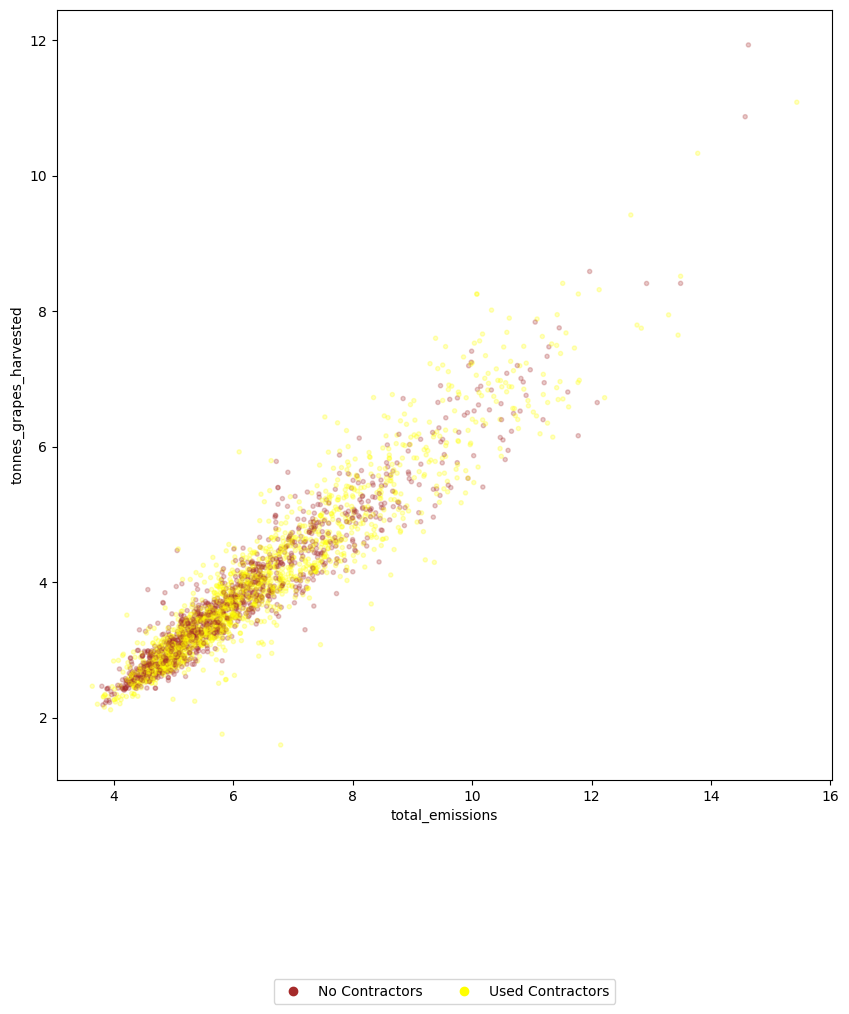

In [216]:
fig, ax = plt.subplots(figsize=(10, 10))

colors = {"No Contractors": "brown", "Used Contractors": "yellow"}

scatter = ax.scatter(
    df["water_and_emmissions"],
    df['yield_avg']
    , c=df["use_contractors"].map(colors)
    , label=df["use_contractors"]
    , marker= "."
    , alpha=0.25
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in df["use_contractors"].map(colors).values]
plt.legend(markers, df["use_contractors"].unique(), loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

plt.show()

<AxesSubplot: >

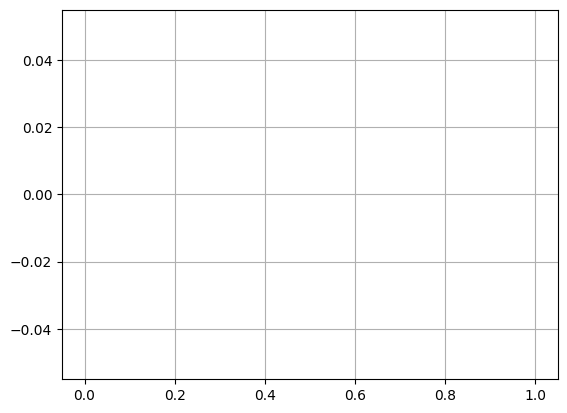

In [218]:
df[df["use_contractors"]=="No Contractors"]["water_and_emmissions"].hist()

<AxesSubplot: >

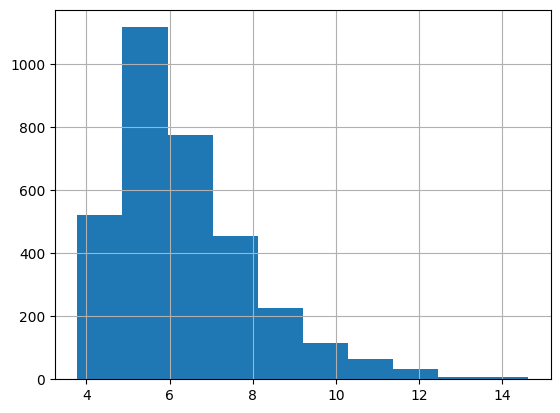

In [197]:
df[df["use_contractors"]==0]["water_and_emmissions"].hist()

In [219]:
df.columns

Index(['member_id', 'data_year_id', 'vineyard_area', 'area_harvested',
       'tonnes_grapes_harvested', 'water_used', 'total_tractor_passes',
       'total_vineyard_fuel', 'total_vineyard_electricity',
       'total_irrigation_area', 'synthetic_nitrogen_applied',
       'organic_nitrogen_applied', 'synthetic_fertiliser_applied',
       'organic_fertiliser_applied', 'area_not_harvested',
       'total_irrigation_electricity', 'total_irrigation_fuel', 'giregion',
       'fertilizer_s1', 'fertilizer_s2', 'fertilizer_s3', 'fertilizer_s4',
       'fertilizer_s5', 'fertilizer_o1', 'fertilizer_o2', 'fertilizer_o3',
       'fertilizer_o4', 'fertilizer_o5', 'vineyard_area_white_grapes',
       'vineyard_area_red_grapes', 'river_water', 'groundwater',
       'surface_water_dam', 'recycled_water_from_other_source', 'mains_water',
       'other_water', 'water_applied_for_frost_control', 'bare_soil',
       'annual_cover_crop', 'permanent_cover_crop_native',
       'permanent_cover_crop_non_native

In [220]:
df["use_renewables"] = df['irrigation_energy_solar'].replace({np.nan: 0}) +\
       df['vineyard_solar'].replace({np.nan: 0}) +\
       df['vineyard_wind'].replace({np.nan: 0}) +\
       df['biodiesel_vineyard'].replace({np.nan: 0})
df.loc[df["use_renewables"] > 0, "use_renewables"] = 1
df["use_renewables"] = df["use_renewables"].map({0: "No Renewables", 1: "Used Renewables"})
df["use_renewables"]

3351      No Renewables
5043    Used Renewables
3116    Used Renewables
2033      No Renewables
671       No Renewables
             ...       
1949      No Renewables
3383      No Renewables
3491      No Renewables
3384      No Renewables
5022      No Renewables
Name: use_renewables, Length: 5189, dtype: object

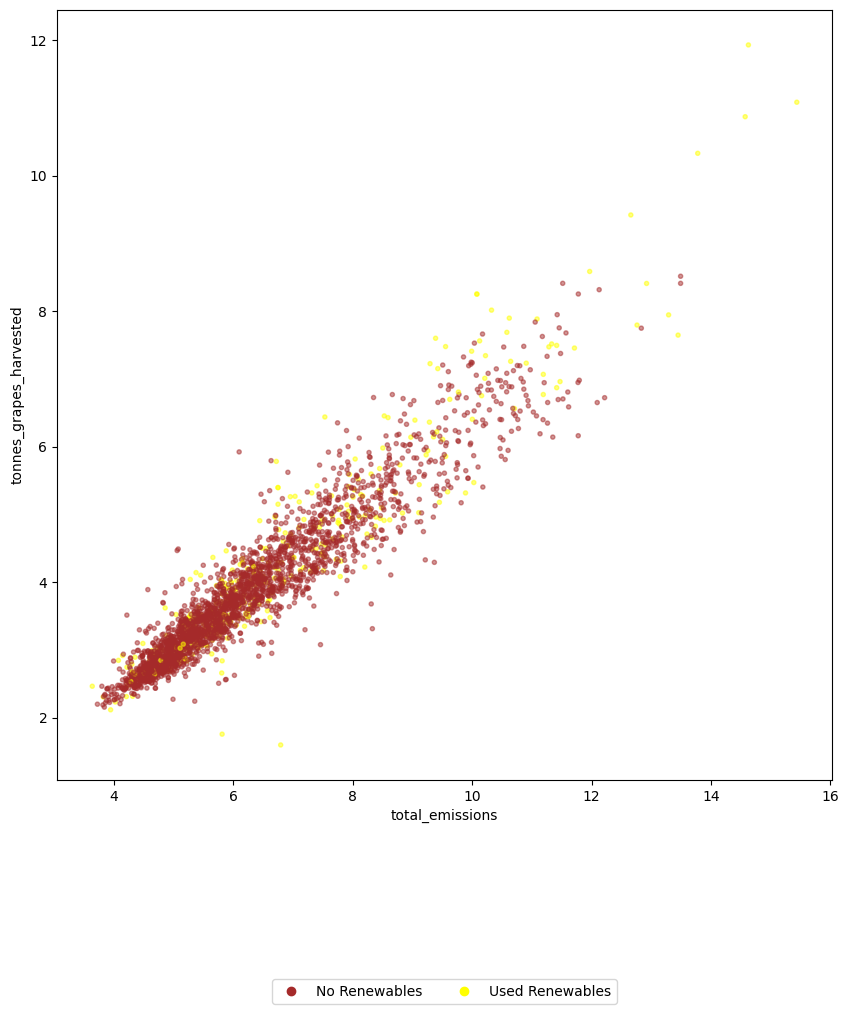

In [231]:
fig, ax = plt.subplots(figsize=(10, 10))

colors = {"No Renewables": "brown", "Used Renewables": "yellow"}

scatter = ax.scatter(
    df["water_and_emmissions"],
    df['yield_avg']
    , c=df["use_renewables"].map(colors)
    , label=df["use_renewables"]
    , marker= "."
    , alpha=0.5
)
ax.set_xlabel(feature)
ax.set_ylabel('tonnes_grapes_harvested')
ax.set(xlabel=feature, ylabel='tonnes_grapes_harvested')

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in df["use_renewables"].map(colors).values]
plt.legend(markers, df["use_renewables"].unique(), loc='lower center', bbox_to_anchor=(0.5, -.3), ncol=6)

plt.show()